# Проект "Отток клиентов"

## Описание проекта  и данных

Банку необходимо научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. 

- Командой банка были собраны следующие данные:
  - Табличные клиентские данные:
    - **clients.csv** - базовая информация про всех 96,000 клиентов в табличном .csv формате:
      - *user_id* - ID клиента банка;
      - *report* - номер одного из 12 отчетов, в который попал этот клиент;
      - *employee_count_nm* - информация о работодателе клиента: число сотрудников в компании;
      - *bankemplstatus* - информация о том, является ли клиент сотрудником банка;
      - *customer_age* - обфусцированный возраст клиента (до одной из 4 групп 0,1,2,3);
    - **train.csv** - тренировочные данные по целевой переменной и времени последней транзакции для 64,000 клиентов:
      - *user_id* - ID клиента банка;
      - *target* - метка оттока клиента (целевой класс события оттока - это 1);
      - *time*- через сколько дней случится последняя транзакция клиента (можно использовать как survival time в Time-to-Event анализе);
    - **report_dates.csv** - информация об отчетах, в рамках которых клиенты сгруппированы по времени
      - *report* - порядковый номер отчета;
      - *report_dt* - дата отчета;
  - Данные клиентских транзакций - клиентские транзакции для всех 96,000 клиентов в табличном .csv формате - **transactions.csv**:
    - *user_id* - ID клиента банка;
    - *mcc_code* - mcc код транзакции;
    - *currency_rk* - валюта транзакции;
    - *transaction_dttm* - дата и время совершения операции;
    - *transaction_amt* - сумма в валюте транзакции;
  - Сопроводительные данные:
    - **mcc_codes.csv** - расшифровка МСС кодов транзакций:
      - *mcc* - код транзакции;
      - *Название* - название транзакции;
      - *Описание* - описание транзакции;
    - **currency_rk.csv** - расшифровка кодов валют:
      - *currency_rk* - код валюты транзакции;
      - *Name* - расшифровка кода валюты транзакции;
  - Примеры решений  - **sample_submit_naive.csv** - базовый пример валидного решения;
- Стоит задача бинарной классификации: 1 - клиент ушел, 0 - клиент не ушел;
- Предварительно необходимо предсказать время до последней транзакции 'time' для 'user_id', не имеющих этого признака  (задача регрессии);

## План работы
- Шаг 1:
  1) Загрузка данных;
  2) Анализ данных;
- Шаг 2:
  1) Объединение таблиц;
  2) Создание фичей;
- Шаг 3 Обучение:
  1) Первый этап обучения: предсказание времени до последней транзакции 'time' для 'user_id', не имеющих этого признака;
  2) Подготовка данных к обучению;
  3) Обучение с прологарифмированной целевой переменной;
  4) Обучение с непрологарифмированной целевой переменной;
  5) Второй этап обучения: предсказание вероятности оттока клиентов по предсказанному времени до последней транзакции;

# 1 Загрузка данных и первичный анализ

## 1.1 Загрузка данных

In [1]:
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import catboost as cat
import time

from skimpy import clean_columns
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    roc_auc_score,
    accuracy_score,
    f1_score,
    recall_score, 
    precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve, 
    auc
)

warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

RANDOM = 42

In [2]:
clients = pd.read_csv('/Users/Elena/Desktop/Задание/Задание/clients.csv')
currency_rk = pd.read_csv('/Users/Elena/Desktop/Задание/Задание/currency_rk.csv')
mcc_codes = pd.read_csv('/Users/Elena/Desktop/Задание/Задание/mcc_codes.csv')
report_dates = pd.read_csv('/Users/Elena/Desktop/Задание/Задание/report_dates.csv')
sample_submit_naive = pd.read_csv('/Users/Elena/Desktop/Задание/Задание/sample_submit_naive.csv')  
train = pd.read_csv('/Users/Elena/Desktop/Задание/Задание/train.csv')
transactions = pd.read_csv('/Users/Elena/Desktop/Задание/Задание/transactions.csv')
test = pd.read_csv('/Users/Elena/Desktop/Задание/Задание/sample_submit_naive.csv')

In [3]:
# Приведем названия столбцов датафреймов к snake_case в соответствии с PEP8
dfs = [clients, currency_rk, mcc_codes, report_dates, sample_submit_naive, train, transactions]
for i in range(len(dfs)):
    dfs[i] = clean_columns(dfs[i])

clients, currency_rk, mcc_codes, report_dates, sample_submit_naive, train, transactions = dfs

In [4]:
def df_research(data):
    """
    Функция исследования данных таблицы: 
    выводит 5 случайных строк, информацию, описание, количество явных дубликатов, 
    количество пропусков, количество уникальных значений в столбцах
    """
    print('Случайные строки датафрейма:')
    display(data.sample(n=5, random_state = RANDOM))
    print('\nИнформация о датафрейме:')
    data.info()
    print('\nОписание данных датафрейма:')
    display(data.describe())
    print('\nКоличество явных дубликатов:', data.duplicated().sum())
    print('\nКоличество пропусков:\n', data.isna().sum())
    print('\nКоличество уникальных значений:\n', data.nunique())

In [5]:
def values_hist(df, columns):
    """
    Функция выводит количество уникальных значений и распределение значений выбранных столбцов
    """
    for column_name in columns:
        if column_name in df.columns:
            values = df[column_name].value_counts(ascending=False, dropna=False)
            print(f"Столбец: {column_name}")
            print(f"Количество уникальных значений: {values}")
            
            plt.figure(figsize=(8, 6))
            df[column_name].value_counts(dropna=False).plot(kind='bar')
            plt.xlabel(column_name)
            plt.ylabel('Количество')
            plt.title(f"Гистограмма для столбца '{column_name}'")
            plt.xticks(rotation=45)
            plt.show()
        else:
            print(f"Столбец '{column_name}' не найден в датафрейме.")

## 1.2 Анализ данных

## 1.2.1 Датасет clients

In [6]:
df_research(clients)

Случайные строки датафрейма:


user_id  report employee_count_nm  bankemplstatus  customer_age
83250   477433      11               NaN               0             3
71978   414586       6               NaN               0             3
47489   275175      11      ОТ 51 ДО 100               0             3
94910   546870      12               NaN               0             3
18844   107205       2     ОТ 101 ДО 500               0             1


Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96000 entries, 0 to 95999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            96000 non-null  int64 
 1   report             96000 non-null  int64 
 2   employee_count_nm  59534 non-null  object
 3   bankemplstatus     96000 non-null  int64 
 4   customer_age       96000 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.7+ MB

Описание данных датафрейма:


user_id    report  bankemplstatus  customer_age
count  96,000.00 96,000.00       96,000.00     96,000.00
mean  276,382.61      6.61            0.00          1.61
std   159,494.18      3.44            0.06          1.18
min         3.00      1.00            0.00          0.00
25%   136,955.00      4.00            0.00          0.00
50%   277,938.00      7.00            0.00          2.00
75%   414,695.25     10.00            0.00          3.00
max   562,740.00     12.00            1.00          3.00


Количество явных дубликатов: 0

Количество пропусков:
 user_id                  0
report                   0
employee_count_nm    36466
bankemplstatus           0
customer_age             0
dtype: int64

Количество уникальных значений:
 user_id              96000
report                  12
employee_count_nm        9
bankemplstatus           2
customer_age             4
dtype: int64


Столбец: report
Количество уникальных значений: report
12    8361
11    8311
10    8223
9     8164
8     8119
7     8106
6     7974
5     7929
4     7853
3     7787
2     7660
1     7513
Name: count, dtype: int64


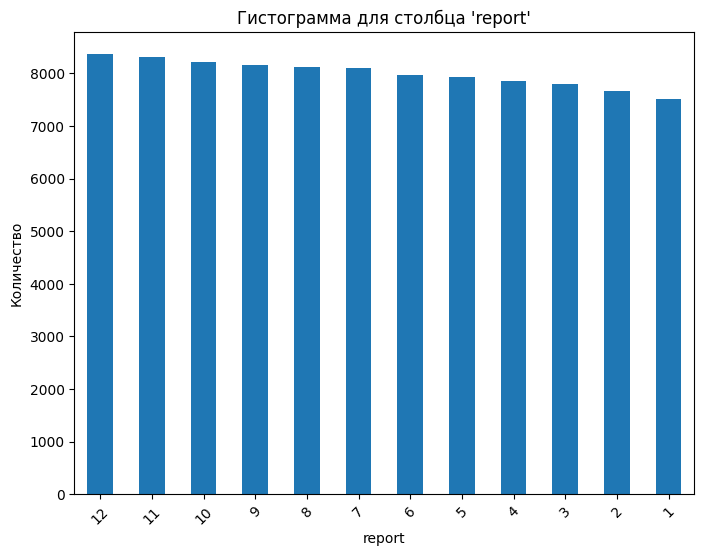

Столбец: employee_count_nm
Количество уникальных значений: employee_count_nm
NaN               36466
БОЛЕЕ 1001        17833
ОТ 101 ДО 500     14362
ОТ 51 ДО 100       7314
ОТ 501 ДО 1000     6481
ОТ 11 ДО 50        4413
ДО 10              3797
БОЛЕЕ 500          1996
ОТ 11 ДО 30        1871
ОТ 31 ДО 50        1467
Name: count, dtype: int64


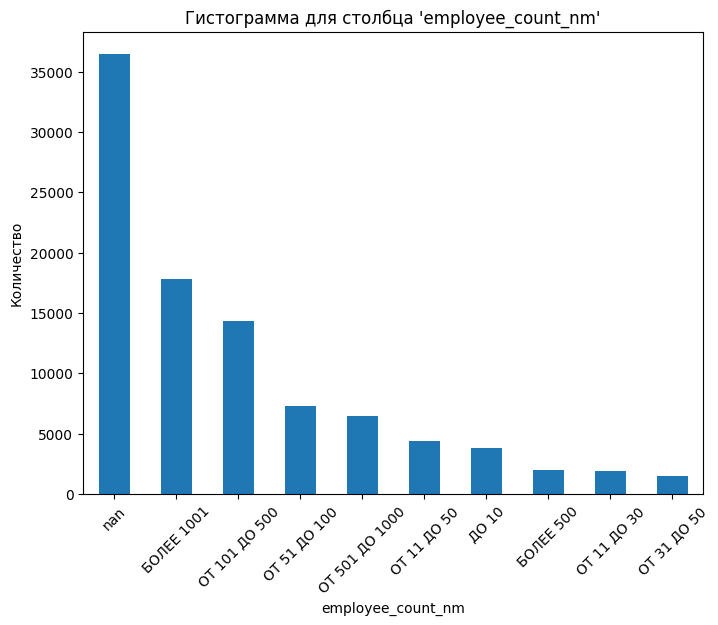

Столбец: bankemplstatus
Количество уникальных значений: bankemplstatus
0    95687
1      313
Name: count, dtype: int64


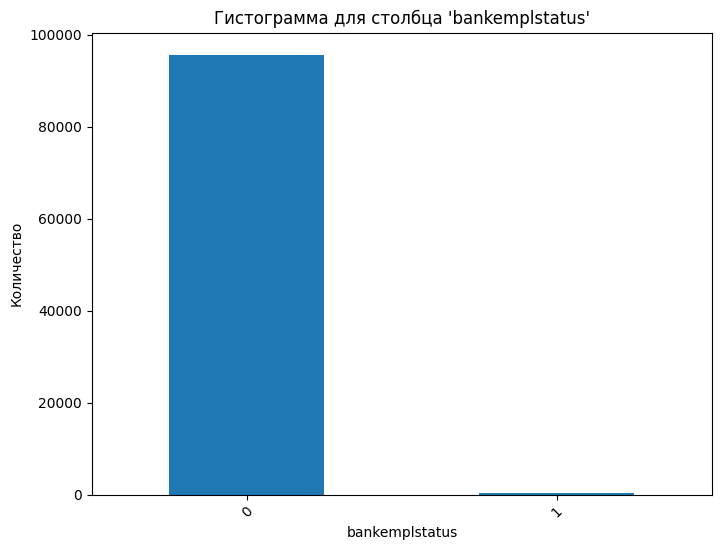

Столбец: customer_age
Количество уникальных значений: customer_age
3    30964
0    24401
2    21470
1    19165
Name: count, dtype: int64


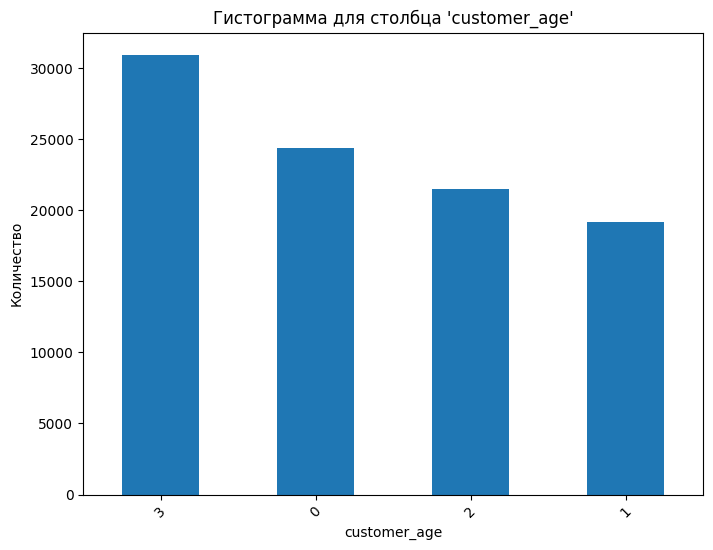

In [7]:
columns_to_plot = ['report', 'employee_count_nm', 'bankemplstatus', 'customer_age']
values_hist(clients, columns_to_plot)

Для лучшего анализа можно объединить группы по количеству сотрудников в более крупные категории. Создадим следующие группы:

1. **Малые предприятия**: 'ДО 10', 'ОТ 11 ДО 30', 'ОТ 11 ДО 50', 'ОТ 31 ДО 50'
2. **Средние предприятия**: 'ОТ 51 ДО 100', 'ОТ 101 ДО 500'
3. **Крупные предприятия**: 'БОЛЕЕ 500', 'ОТ 501 ДО 1000', 'БОЛЕЕ 1001'
4. **Неизвестно**: "NaN"

Создадим новый столбец 'employee_category', который содержит категорию для каждого значения в employee_count_nm.

In [8]:
# Функция для группировки
def categorize_employee_count(count):
    if pd.isna(count):
        return 'Неизвестно'
    elif count in ['ДО 10', 'ОТ 11 ДО 30', 'ОТ 11 ДО 50', 'ОТ 31 ДО 50']:
        return 'Малые предприятия'
    elif count in ['ОТ 51 ДО 100', 'ОТ 101 ДО 500']:
        return 'Средние предприятия'
    elif count in ['БОЛЕЕ 500', 'ОТ 501 ДО 1000', 'БОЛЕЕ 1001']:
        return 'Крупные предприятия'
    else:
        return count

In [9]:
# Применяем функцию к столбцу 'employee_category'
clients['employee_category'] = clients['employee_count_nm'].apply(categorize_employee_count)

clients.head()

user_id  report employee_count_nm  bankemplstatus  customer_age  \
0        3       2     ОТ 101 ДО 500               0             3   
1        9       1        БОЛЕЕ 1001               0             3   
2       13       6    ОТ 501 ДО 1000               0             2   
3       37       5        БОЛЕЕ 1001               0             2   
4       41       1     ОТ 101 ДО 500               0             2   

     employee_category  
0  Средние предприятия  
1  Крупные предприятия  
2  Крупные предприятия  
3  Крупные предприятия  
4  Средние предприятия

Столбец: employee_category
Количество уникальных значений: employee_category
Неизвестно             36466
Крупные предприятия    26310
Средние предприятия    21676
Малые предприятия      11548
Name: count, dtype: int64


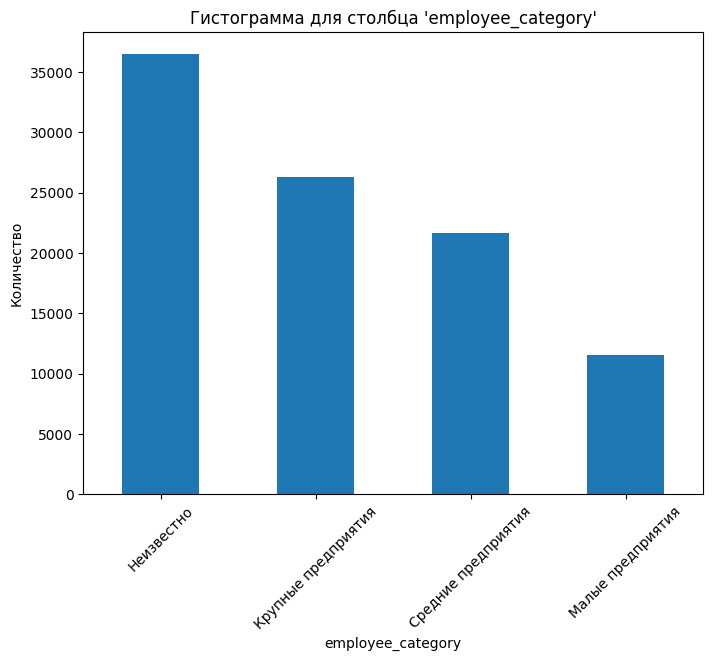

In [10]:
columns_to_plot = ['employee_category']
values_hist(clients, columns_to_plot)

**В датасете clients**:
- 96000 строк;
- Явные дубликаты отсутствуют;
- Все id клиентов банка уникальны;
- **Номер отчета 'report'**:
  - Имеем 12 отчетов 'report', наблюдаем тенденцию к уменьшению количества клиентов по мере увеличения номера отчета. Наиболее популярный отчет — это 12-й, с наибольшим количеством клиентов (8361), а наименее популярный — 1-й (7513). Это может указывать на то, что клиенты чаще попадают в более поздние отчеты.
  - В целом, клиенты распределены равномерно по отчетам;
- **Число сотрудников в компании клиента 'employee_count_nm' и категория предприятия 'employee_category'**:
  - **Большое количество неопределенных данных**: пропуски есть только в столбце 'employee_count_nm' (число сотрудников в компании клиента) - 36466 пропусков, что составляет почти половину от общего числа клиентов. Это может указывать на необходимость улучшения процесса сбора данных или их обработки;
  - **Сравнительно высокое количество крупных и средних предприятий**: крупные предприятия (26,310) и средние предприятия (21,676) составляют значительную часть выборки. Это может свидетельствовать о том, что в базе данных преобладают более крупные компании, что может быть полезно для целевых маркетинговых стратегий или бизнес-анализа;
  - **Низкое представительство малых предприятий**: количество малых предприятий (11,548) значительно меньше по сравнению с крупными и средними. Это может указывать на недостаточную активность малых компаний или на сложности в их идентификации;
- **Является ли клиент сотрудником банка 'bankemplstatus'**:
  - **Преобладание клиентов, не являющихся сотрудниками банка**: Большинство клиентов (95,687) не являются сотрудниками банка (значение 0). Это составляет более 99% от общего числа записей. Это может указывать на то, что ваша клиентская база в основном состоит из обычных потребителей или бизнесов, а не из банковских работников;
  - **Небольшое количество сотрудников банка**: Всего 313 клиентов имеют статус сотрудника банка (значение 1). Это менее 1% от общего числа клиентов, что говорит о том, что эта категория клиентов значительно меньше по сравнению с основной массой;
- **Обфусцированный возраст клиента 'customer_age' (до одной из 4 групп 0,1,2,3)**:
  - **Преобладание группы 3**: Наибольшее количество клиентов (30,964) относится к группе 3. Это может указывать на то, что большинство клиентов попадают в эту возрастную категорию, что может быть связано с определенными характеристиками или предпочтениями, характерными для этой группы;
  - **Сравнительное количество других групп**: Группа 0 (24,401) также имеет значительное количество клиентов, но меньше, чем группа 3. Группы 2 (21,470) и 1 (19,165) имеют примерно равное и меньшее количество клиентов. Это может говорить о том, что возрастные группы 1 и 2 менее представлены среди клиентской базы;

## 1.2.2 Датасет Train

In [11]:
df_research(train)

Случайные строки датафрейма:


user_id  target  time
33042   287176       0    91
7209     61447       0    91
24367   210716       0    91
19599   168576       0    91
31465   273446       0    83


Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  64000 non-null  int64
 1   target   64000 non-null  int64
 2   time     64000 non-null  int64
dtypes: int64(3)
memory usage: 1.5 MB

Описание данных датафрейма:


user_id    target      time
count  64,000.00 64,000.00 64,000.00
mean  276,392.92      0.08     79.90
std   159,666.90      0.28     18.75
min         3.00      0.00      1.00
25%   136,699.00      0.00     79.00
50%   278,146.50      0.00     89.00
75%   414,635.75      0.00     91.00
max   562,740.00      1.00     91.00


Количество явных дубликатов: 0

Количество пропусков:
 user_id    0
target     0
time       0
dtype: int64

Количество уникальных значений:
 user_id    64000
target         2
time          91
dtype: int64


Столбец: target
Количество уникальных значений: target
0    58583
1     5417
Name: count, dtype: int64


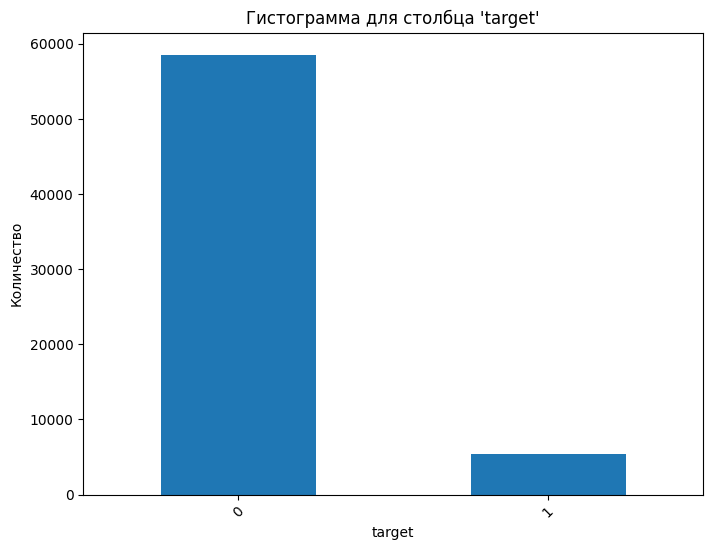

In [12]:
columns_to_plot = ['target']
values_hist(train, columns_to_plot)

In [13]:
# Посмотрим на баланс классов
train['target'].value_counts(dropna=False, normalize=True)

target
0   0.92
1   0.08
Name: proportion, dtype: float64

**Присутствует явный дисбаланс классов**, объектов отрицательного класса (93%) в 13 с лишним раз больше объектов положительного класса (0.07%). Необходимо будет учитывать это при обучении.

In [14]:
fig = px.histogram(
    train, 
    x="time",
    title='Гистограмма для столбца time'
)
fig.show()

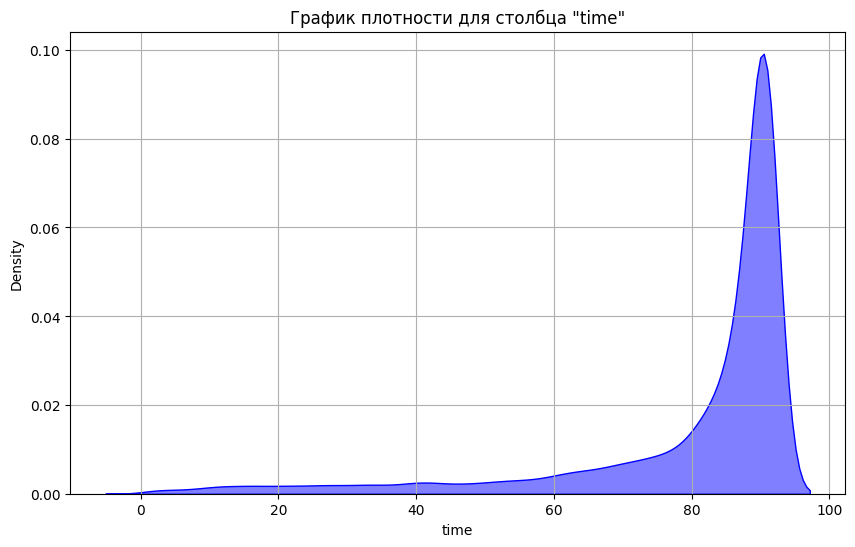

In [15]:
# Создание графика плотности
plt.figure(figsize=(10, 6))
sns.kdeplot(train['time'], fill=True, color='blue', alpha=0.5)

# Настройка графика
plt.title('График плотности для столбца "time"')
plt.xlabel('time')
plt.ylabel('Density')
plt.grid()

# Показать график
plt.show();

In [16]:
train['time'].unique()

array([77, 86, 89, 57, 84, 91, 88, 28, 90, 78, 87, 61, 41, 85, 68, 82,  5,
       59, 81, 80, 39, 18, 37, 83, 70, 53, 75, 73, 49, 72, 58,  7, 71, 35,
       34, 16, 74, 54, 65, 64, 76, 51, 12, 33, 29, 62, 46, 22, 79, 26,  8,
        9, 21,  1, 55, 52, 63, 42, 31, 69, 50, 38,  4, 24, 27, 30, 67, 60,
       25, 47, 45, 20, 19, 17,  6, 66, 43, 11, 48, 13, 14, 56, 44,  3, 23,
       40, 32, 36, 10, 15,  2])

**В датасете train**:
- 64000 строк;
- Пропуски отсутствуют;
- Явные дубликаты отсутствуют;
- **Метка оттока клиентов 'target'**:
  - 5417 клиентов покинули банк, 58583 остались;     
  - **Дисбаланс классов**: класс 0 (клиенты, не покинувшие компанию) значительно преобладает над классом 1 (клиенты, покинувшие компанию). Соотношение составляет примерно 13:1, что указывает на сильный дисбаланс. Это может привести к проблемам при обучении модели, так как она может игнорировать менее представленный класс. Необходимо учитывать данную информацию при обучении;
  - **Риск переобучения**: модели могут склоняться к предсказанию класса 0, что приведет к высокой общей точности, но низкой точности для класса 1. Это означает, что модель может не улавливать важные паттерны, связанные с оттоком клиентов;
- **Время до последней транзакции клиента 'time'**:
  - **Среднее значение (mean)**: среднее значение времени до последней транзакции составляет примерно 79.90 дней. Это указывает на то, что в среднем клиенты имеют относительно короткий период активности перед оттоком;
  - **Минимальное и максимальное значения**:
    - Минимальное значение равно 1 дню, что может означать, что некоторые клиенты перестали совершать транзакции сразу после последнего отчета;
    - Максимальное значение составляет 91 день, что соответствует верхнему пределу для "клинического оттока", как описано в задаче;
  - **Квартильные значения**: 25-й процентиль (79 дней) и медиана (89 дней) показывают, что большая часть клиентов имеет время до последней транзакции в диапазоне от 79 до 91 дня. Это также подтверждает, что большинство клиентов находятся на грани "клинического оттока";
  - Выводы и рекомендации:
    - **Раннее выявление оттока**: Учитывая, что среднее значение времени до последней транзакции близко к 80 дням, важно внедрить проактивные меры для выявления клиентов, которые могут быть на грани оттока. Модели предсказания оттока должны учитывать клиентов с временем до последней транзакции около 80 дней;
    - **Сегментация клиентов**: Можно рассмотреть возможность сегментации клиентов на основе времени до последней транзакции. Например, клиенты с меньшим временем до последней транзакции могут требовать более активного взаимодействия со стороны банка;
    - **Мониторинг и интервенция**: Для клиентов, у которых время до последней транзакции приближается к 90 дням, следует разработать стратегии удержания, такие как специальные предложения или программы лояльности;
    - **Анализ причин оттока**: Важно понять причины, по которым клиенты прекращают транзакции. Это может включать анализ качества обслуживания, конкурентоспособности предложений и удовлетворенности клиентов

## 1.2.3 Датасет Report_dates

In [17]:
df_research(report_dates)

Случайные строки датафрейма:


report            report_dt
10      11  2023-05-31 03:00:00
9       10  2023-04-30 03:00:00
0        1  2022-07-31 03:00:00
8        9  2023-03-31 03:00:00
5        6  2022-12-31 03:00:00


Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   report     12 non-null     int64 
 1   report_dt  12 non-null     object
dtypes: int64(1), object(1)
memory usage: 320.0+ bytes

Описание данных датафрейма:


report
count   12.00
mean     6.50
std      3.61
min      1.00
25%      3.75
50%      6.50
75%      9.25
max     12.00


Количество явных дубликатов: 0

Количество пропусков:
 report       0
report_dt    0
dtype: int64

Количество уникальных значений:
 report       12
report_dt    12
dtype: int64


In [18]:
report_dates

report            report_dt
0        1  2022-07-31 03:00:00
1        2  2022-08-31 03:00:00
2        3  2022-09-30 03:00:00
3        4  2022-10-31 03:00:00
4        5  2022-11-30 03:00:00
5        6  2022-12-31 03:00:00
6        7  2023-01-31 03:00:00
7        8  2023-02-28 03:00:00
8        9  2023-03-31 03:00:00
9       10  2023-04-30 03:00:00
10      11  2023-05-31 03:00:00
11      12  2023-06-30 03:00:00

In [19]:
# Преобразуем столбец 'report_dt' в формат datetime 
report_dates['report_dt'] = pd.to_datetime(report_dates['report_dt'])

In [20]:
df_research(report_dates)

Случайные строки датафрейма:


report           report_dt
10      11 2023-05-31 03:00:00
9       10 2023-04-30 03:00:00
0        1 2022-07-31 03:00:00
8        9 2023-03-31 03:00:00
5        6 2022-12-31 03:00:00


Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   report     12 non-null     int64         
 1   report_dt  12 non-null     datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 320.0 bytes

Описание данных датафрейма:


report            report_dt
count   12.00                   12
mean     6.50  2023-01-14 13:00:00
min      1.00  2022-07-31 03:00:00
25%      3.75  2022-10-23 09:00:00
50%      6.50  2023-01-15 15:00:00
75%      9.25  2023-04-07 15:00:00
max     12.00  2023-06-30 03:00:00
std      3.61                  NaN


Количество явных дубликатов: 0

Количество пропусков:
 report       0
report_dt    0
dtype: int64

Количество уникальных значений:
 report       12
report_dt    12
dtype: int64


**В датасете report_dates:**
- Пропуски отсутствуют;
- Явные дубликаты отсутствуют;
- Количество отчетов равно количеству месяцев - 12;

## 1.2.4 Датасет Mcc_codes

In [21]:
mcc_codes

mcc                                                              header  \
0     742                                                 Ветеринарные услуги   
1     763                                    Сельскохозяйственные кооперативы   
2     780                           Услуги садоводства и ландшафтного дизайна   
3    1520         Генеральные подрядчики – жилое и коммерческое строительство   
4    1711  Генеральные подрядчики по вентиляции, теплоснабжению и водопроводу   
..    ...                                                                 ...   
380  9311                                                   Налоговые платежи   
381  9399          Государственные услуги - нигде более не классифицированные   
382  9402                            Почтовые услуги – только государственные   
383  9405              Внутригосударственные закупки - только государственные   
384  9406                                 Государственные лотереи (кроме США)   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           header_1  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        Лицензированные специалисты в основном занимающиеся практикой ветеринарии, стоматологии или хирургии для всех видов животных; таких как домашние животные (например, собаки, кошки, рыба), домашний скот и другие фермерские животные (например, рогатый скот, лошади, овцы, свиньи, козы, домашние птицы, пчелы) и экзотические животные.  
1                                                                                                                                                                                                                                                                                                                                                                       Ассоциации и кооперативы, которые предоставляют услуги управления фермами или оказывают помощь в сельскохозяйственных операциях. Примерами таких услуг являются финансовая помощь, управление или полное содержание сельскохозяйственных культур, подготовка почвы, посадка и культивация, аэрофотосжигание и распыление, борьба с болезнями и насекомыми, борьба с сорняками и сбор урожая.\nДля точек, которые предоставляют складские помещения и хранилища ферм, используется MCC 4225.  
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [22]:
df_research(mcc_codes)

Случайные строки датафрейма:


mcc                     header  \
268  6300  Услуги страховых компаний   
250  5976      Ортопедические товары   
355  8049                   Ортопеды   
332  7832                 Кинотеатры   
56   3366          Budget Rent-a-car   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     header_1  
268  Розничные торговые точки, которые продают все виды личных или коммерческих страховых полисов, включая страхование автомобилей, жизни, здоровья, прав собственности на недвижимость, медицинские и стоматологические страховки, страхование для домовладельцев и арендаторов, страхование здоровья домашних животных, страхование от наводнений, пожаров или землетрясений.\n\nДля точек, которые продают страховые продукты и услуги с использованием методов прямого маркетинга, используется MCC 5960.  
250                                                                Розничные торговые точки, которые продают различные ортопедические товары, протезы и которые также могут заниматься их починкой. Товары для продажи могут включать костыли, палочки и др. вспомогательные детали для передвижения, эластичный трикотаж, абдоминальные поддержатели, обвязки, растяжки, инвалидные коляски, и т.п. \nДля торговых точек, которые первоначально занимаются починкой подобных товаров, используется МСС 7699.  
355                                                                                                                                                                                                                                                                                                                                                                                                                          Лицензированные врачи, специализирующиеся на диагностике и лечении болезней ноги  
332                                                                                                                                                                                                                                                                                          Точки, которые управляют кинотеатрами, в том числе под открытым небом (drive-in). Такие продавцы продают билеты и напитки и могут предлагать или не предлагать предварительное бронирование билетов по телефону.  
56                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        NaN


Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385 entries, 0 to 384
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   mcc       385 non-null    int64 
 1   header    385 non-null    object
 2   header_1  290 non-null    object
dtypes: int64(1), object(2)
memory usage: 9.1+ KB

Описание данных датафрейма:


mcc
count   385.00
mean  5,511.46
std   1,858.49
min     742.00
25%   3,692.00
50%   5,641.00
75%   7,251.00
max   9,406.00


Количество явных дубликатов: 0

Количество пропусков:
 mcc          0
header       0
header_1    95
dtype: int64

Количество уникальных значений:
 mcc         385
header      378
header_1    289
dtype: int64


In [23]:
display(mcc_codes[mcc_codes['header'] == 'Отели, мотели, курорты'])

mcc                  header header_1
80   3604  Отели, мотели, курорты      NaN
83   3618  Отели, мотели, курорты      NaN
84   3619  Отели, мотели, курорты      NaN
101  3770  Отели, мотели, курорты      NaN
102  3771  Отели, мотели, курорты      NaN
103  3791  Отели, мотели, курорты      NaN
104  3793  Отели, мотели, курорты      NaN

In [24]:
display(mcc_codes[mcc_codes['header'] == 'Денежные переводы'])

mcc             header  \
129  4829  Денежные переводы   
277  6555  Денежные переводы   

                                                                                                                                                                                        header_1  
129  Транзакция, при которой средства доставляются или становятся доступными человеку или счету. Эти транзакции включают транзакции не лицом к лицу, а осуществляемые, например, через Интернет.  
277                                                                                                                                    Прочие денежные переводы не включенные в другие категории

In [25]:
display(mcc_codes[mcc_codes['header_1'].isnull()])

mcc                    header header_1
14   3000           United Airlines      NaN
15   3001         American Airlines      NaN
16   3005           British Airways      NaN
17   3007                Air France      NaN
18   3008                 Lufthansa      NaN
..    ...                       ...      ...
104  3793    Отели, мотели, курорты      NaN
105  3812               Hyatt Place      NaN
106  3813              Hotel Indigo      NaN
107  3826                 Autograph      NaN
108  3835  Dolce Hotels and Resorts      NaN

[95 rows x 3 columns]

**В датасете mcc_codes:**
- Явные дубликаты отсутствуют;
- Есть пропуски в описании mcc кода header_1, но они не требуются, тк понятны из названия header;

## 1.2.5 Датасет Currency_rk

In [26]:
currency_rk

currency_rk name
0           48  RUR
1           50  USD
2           60  EUR

In [27]:
currency_rk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   currency_rk  3 non-null      int64 
 1   name         3 non-null      object
dtypes: int64(1), object(1)
memory usage: 176.0+ bytes


**В датасете currency_rk:**
- 3 валюты транзакций (RUR, USD, EUR);
- Каждой валюте соответствует свой код currency_rk;

## 1.2.6 Датасет Transactions

In [28]:
transactions.head()

user_id  mcc_code  currency_rk  transaction_amt     transaction_dttm
0        3         3            1          -183.88  2022-01-28 12:05:33
1        3         3            1        -3,206.44  2022-01-28 12:52:30
2        3        16            1      -153,866.89  2022-02-16 14:45:56
3        3        56            1       -15,144.60  2022-03-09 19:58:29
4        3         0            1         5,297.91  2022-03-12 18:11:31

In [29]:
df_research(transactions)

Случайные строки датафрейма:


user_id  mcc_code  currency_rk  transaction_amt     transaction_dttm
9221990   367847        11            1           -21.45  2022-03-10 11:18:58
7399292   292054        26            1          -533.64  2022-08-27 15:05:34
8698213   346289         8            1        -1,906.34  2022-07-19 18:35:19
4014915   159782         3            1          -942.57  2022-04-27 02:43:00
7195733   283806         1            1          -522.99  2022-05-18 20:30:07


Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13075023 entries, 0 to 13075022
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   user_id           int64  
 1   mcc_code          int64  
 2   currency_rk       int64  
 3   transaction_amt   float64
 4   transaction_dttm  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 498.8+ MB

Описание данных датафрейма:


user_id      mcc_code   currency_rk  transaction_amt
count 13,075,023.00 13,075,023.00 13,075,023.00    13,075,023.00
mean     262,946.78         14.52          0.97        -1,027.36
std      155,012.50         29.09          0.17        10,535.03
min            3.00          0.00          0.00      -231,368.42
25%      132,012.00          1.00          1.00          -863.47
50%      257,524.00          4.00          1.00          -316.74
75%      392,376.00         13.00          1.00          -113.89
max      562,740.00        449.00          3.00       352,076.81


Количество явных дубликатов: 10

Количество пропусков:
 user_id             0
mcc_code            0
currency_rk         0
transaction_amt     0
transaction_dttm    0
dtype: int64

Количество уникальных значений:
 user_id                96000
mcc_code                 332
currency_rk                4
transaction_amt     11849410
transaction_dttm     9950432
dtype: int64


In [30]:
# Посмотрим на явные дубликаты
duplicates = transactions[transactions.duplicated(keep=False)]
duplicates

user_id  mcc_code  currency_rk  transaction_amt     transaction_dttm
10274876   413253        11            1           -27.61  2022-03-27 04:26:00
10274877   413253        11            1           -27.61  2022-03-27 04:26:00
10274878   413253        11            1           -23.92  2022-03-29 03:41:56
10274879   413253        11            1           -23.92  2022-03-29 03:41:56
10274880   413253         4            1          -185.73  2022-03-30 17:44:29
10274881   413253         4            1          -185.73  2022-03-30 17:44:29
10274882   413253         4            1          -157.93  2022-04-03 18:01:01
10274883   413253         4            1          -157.93  2022-04-03 18:01:01
10274884   413253         1            1          -135.42  2022-06-20 14:47:39
10274885   413253         1            1          -135.42  2022-06-20 14:47:39
10274886   413253         1            1          -227.25  2022-06-23 20:32:33
10274887   413253         1            1          -227.25  2022-06-23 20:32:33
10274888   413253         1            1          -105.05  2022-06-29 17:24:19
10274889   413253         1            1          -105.05  2022-06-29 17:24:19
10274890   413253         1            1          -389.33  2022-06-30 20:31:15
10274891   413253         1            1          -389.33  2022-06-30 20:31:15
10274892   413253         2            1          -180.69  2022-07-01 11:45:11
10274893   413253         2            1          -180.69  2022-07-01 11:45:11
10274894   413253         2            1          -120.59  2022-07-03 21:06:04
10274895   413253         2            1          -120.59  2022-07-03 21:06:04

In [31]:
# Удалим явные дубликаты
transactions = transactions.drop_duplicates(keep='last')

In [32]:
# Преобразуем столбец 'transaction_dttm' в формат datetime 
transactions['transaction_dttm'] = pd.to_datetime(transactions['transaction_dttm'])

**В датасете transactions:**
- Пропуски отсутствуют;
- Явные дубликаты удалены;
- **Сумма в валюте транзакции transaction_amt:**
  - **Общее количество транзакций**: в наборе данных представлено 13,075,023 транзакции;
  - **Средняя сумма транзакции**: средняя сумма транзакции составляет -1,027.36, что указывает на преобладание отрицательных значений (расходов) над положительными (поступлениями);
  - **Стандартное отклонение**: в ысокое стандартное отклонение (10,535.03) свидетельствует о значительном разбросе сумм транзакций, что может означать наличие как мелких, так и крупных операций;
  - **Минимальная и максимальная суммы**: минимальная сумма транзакции составляет -231,368.42, а максимальная — 352,076.81. Это говорит о том, что среди транзакций есть как значительные расходы, так и крупные поступления;
  - **Квартильные значения**:
    - 25% транзакций имеют сумму менее -863.47;
    - Медиана (50%) составляет -316.74, что подтверждает, что половина транзакций имеет суммы, близкие к расходам;
    - 75% транзакций имеют сумму менее -113.89, что также указывает на преобладание расходов;
  - **Общие выводы**: данные показывают, что большинство транзакций представляют собой расходы клиентов, с небольшим количеством поступлений. 

# 2 Создание фичей

Объединим таблицы clients и report_dates. В результате будут оставлены только те строки, где значения в столбце 'report' совпадают в обоих датафреймах.

In [33]:
clients = clients.merge(report_dates, on = 'report', how = 'inner')

In [34]:
clients.head()

user_id  report employee_count_nm  bankemplstatus  customer_age  \
0        3       2     ОТ 101 ДО 500               0             3   
1       90       2     ОТ 101 ДО 500               0             3   
2      146       2      ОТ 51 ДО 100               0             2   
3      275       2     ОТ 101 ДО 500               0             2   
4      572       2               NaN               0             2   

     employee_category           report_dt  
0  Средние предприятия 2022-08-31 03:00:00  
1  Средние предприятия 2022-08-31 03:00:00  
2  Средние предприятия 2022-08-31 03:00:00  
3  Средние предприятия 2022-08-31 03:00:00  
4           Неизвестно 2022-08-31 03:00:00

Преобразуем столбцы 'report_dt' в clients и 'transaction_dttm' в transactions в формат datetime.

In [35]:
clients['report_dt'] = pd.to_datetime(clients['report_dt'])
transactions['transaction_dttm'] = pd.to_datetime(transactions['transaction_dttm'])

Cоздадим новый столбец 'day_x' в clients, который содержит дату, отстоящую на 3 месяца назад от значения в столбце 'report_dt'. То есть, для каждой строки в clients, значение в столбце 'day_x' будет равно значению в столбце 'report_dt' минус 3 месяца. Это позволит определить дату, с которой начинается отсчет времени для каждой записи в clients.

In [36]:
clients['day_x'] = clients['report_dt'] - pd.DateOffset(months=3)

In [37]:
clients.head()

user_id  report employee_count_nm  bankemplstatus  customer_age  \
0        3       2     ОТ 101 ДО 500               0             3   
1       90       2     ОТ 101 ДО 500               0             3   
2      146       2      ОТ 51 ДО 100               0             2   
3      275       2     ОТ 101 ДО 500               0             2   
4      572       2               NaN               0             2   

     employee_category           report_dt               day_x  
0  Средние предприятия 2022-08-31 03:00:00 2022-05-31 03:00:00  
1  Средние предприятия 2022-08-31 03:00:00 2022-05-31 03:00:00  
2  Средние предприятия 2022-08-31 03:00:00 2022-05-31 03:00:00  
3  Средние предприятия 2022-08-31 03:00:00 2022-05-31 03:00:00  
4           Неизвестно 2022-08-31 03:00:00 2022-05-31 03:00:00

Добавим столбец 'day_x' из датафрейма clients в датафрейм transactions. Все строки из transactions будут сохранены, а строки из clients, у которых нет соответствия по 'user_id', будут иметь значения NaN в столбце 'day_x'.

In [38]:
transactions = transactions.merge(clients[['user_id', 'day_x']], on = 'user_id', how = 'left')

In [39]:
transactions.head()

user_id  mcc_code  currency_rk  transaction_amt    transaction_dttm  \
0        3         3            1          -183.88 2022-01-28 12:05:33   
1        3         3            1        -3,206.44 2022-01-28 12:52:30   
2        3        16            1      -153,866.89 2022-02-16 14:45:56   
3        3        56            1       -15,144.60 2022-03-09 19:58:29   
4        3         0            1         5,297.91 2022-03-12 18:11:31   

                day_x  
0 2022-05-31 03:00:00  
1 2022-05-31 03:00:00  
2 2022-05-31 03:00:00  
3 2022-05-31 03:00:00  
4 2022-05-31 03:00:00

Напишем функцию get_dates_delta, которая:
1. Группирует данные по столбцам 'user_id' и 'day_x' в датафрейме txn_data, вычисляя минимальную и максимальную дату транзакции для каждого пользователя. Результат сохраняется в новом датафрейме agg_data.
2. Создает имена столбцов min_col_name и max_col_name, используя переданные аргументы min_feature_name и max_feature_name.
3. Вычисляет разницу в днях между датой в столбце 'day_x' и минимальной/максимальной датой транзакции для каждого пользователя. Результат сохраняется в новых столбцах min_col_name и max_col_name в agg_data.
4. Объединяет датафрейм features_data с agg_data по столбцу 'user_id' с использованием операции left join. Это добавляет новые столбцы min_col_name и max_col_name к features_data на основе 'user_id'.
5. Возвращает обновленный датафрейм features_data с добавленными столбцами min_col_name и max_col_name, содержащими разницу в днях между 'day_x' и минимальной/максимальной датой транзакции для каждого пользователя.

In [40]:
def get_dates_delta(txn_data, features_data, min_feature_name, max_feature_name):
    """
    Функция предназначена для расчета разницы в днях между датой транзакции и 
    минимальной/максимальной датой транзакции для каждого пользователя. 
    Добавляет информацию о временных интервалах между первой и последней транзакцией 
    для каждого пользователя в данные о признаках.
    """
    # Группировка данных по 'user_id' и 'day_x' с агрегацией минимальной и максимальной дат транзакций
    agg_data = txn_data.groupby(['user_id', 'day_x'])['transaction_dttm'].agg({'min', 'max'}).reset_index()
    
    # Создание названий столбцов для разницы в днях между первой и последней транзакциями
    min_col_name = f'{min_feature_name}first_txn_delta'
    max_col_name = f'{max_feature_name}last_txn_delta'

    # Расчет разницы в днях между датой транзакции и минимальной/максимальной датой для каждого пользователя
    agg_data[min_col_name] = (agg_data['day_x'] - agg_data['min']).dt.days
    agg_data[max_col_name] = (agg_data['day_x'] - agg_data['max']).dt.days
    
    # Объединение данных о признаках с данными о временных интервалах между транзакциями
    features_data = features_data.merge(agg_data[['user_id', min_col_name, max_col_name]],
                                        on='user_id', how='left')
    
    return features_data

## 2.1 Разница в днях между первой и последней транзакциями для всех транзакций каждого пользователя:
- **2.1.1** **Для всех транзакций**
- **2.1.2** **Для положительных транзакций**
- **2.1.3** **Для отрицательных транзакций**

1. Создадим датафрейм features_data, который содержит только столбец 'user_id' из clients.
2. Вызовем функцию get_dates_delta три раза для обработки различных типов транзакций:
   - Первый вызов без фильтрации по сумме транзакции (transaction_amt), добавляя новые столбцы в features_data без префиксов (то есть данные не фильтруются по сумме транзакции (transaction_amt). Все транзакции учитываются независимо от их значения. Новые столбцы, которые добавляются к features_data, не имеют префикса в своем названии. Это позволяет получить информацию о разнице в днях между датой каждой транзакции и минимальной/максимальной датой транзакции для каждого пользователя в общем виде, без разделения на положительные и отрицательные суммы транзакций).
   - Второй вызов с фильтрацией по положительной сумме транзакции (transaction_amt > 0), добавляя новые столбцы в features_data с префиксом 'plus_'.
   - Третий вызов с фильтрацией по отрицательной сумме транзакции (transaction_amt < 0), добавляя новые столбцы в features_data с префиксом 'minus_'.

Каждый вызов функции get_dates_delta добавляет новые столбцы к features_data, содержащие информацию о разнице в днях между датой транзакции и минимальной/максимальной датой транзакции для каждого пользователя, в зависимости от условий фильтрации.

In [41]:
# Создание DataFrame с колонкой 'user_id' из clients
features_data = clients[['user_id']]

# Расчет разницы в днях между первой и последней транзакциями для всех транзакций
features_data = get_dates_delta(transactions, features_data, '', '')

# Расчет разницы в днях между первой и последней положительной транзакциями
features_data = get_dates_delta(transactions.query('transaction_amt > 0'), features_data, 'plus_', 'plus_')

# Расчет разницы в днях между первой и последней отрицательной транзакциями
features_data = get_dates_delta(transactions.query('transaction_amt < 0'), features_data, 'minus_', 'minus_')

features_data.head()

user_id  first_txn_delta  last_txn_delta  plus_first_txn_delta  \
0        3              122              16                 79.00   
1       90              191              17                 58.00   
2      146              191               9                189.00   
3      275              171              17                171.00   
4      572              191               9                129.00   

   plus_last_txn_delta  minus_first_txn_delta  minus_last_txn_delta  
0                16.00                 122.00                 82.00  
1                46.00                 191.00                 17.00  
2                18.00                 191.00                  9.00  
3                17.00                 171.00                 28.00  
4                11.00                 191.00                  9.00

## 2.2 Медианное значение временного интервала между транзакциями для каждого пользователя

In [42]:
# Копирование нужных колонок 'user_id' и 'transaction_dttm' из DataFrame transactions
txn_data = transactions[['user_id', 'transaction_dttm']].copy()

# Преобразование даты транзакции в формат даты (без времени)
txn_data['transaction_dttm'] = txn_data['transaction_dttm'].dt.date

# Преобразование столбца 'transaction_dttm' в тип данных datetime
txn_data['transaction_dttm'] = pd.to_datetime(txn_data['transaction_dttm'])

# Создание нового столбца 'lead_transaction_dttm' с предыдущей транзакцией для каждого пользователя:
# столбец 'lead_transaction_dttm'содержит дату предыдущей транзакции для каждого пользователя, 
# сортируя данные по 'user_id' и 'transaction_dttm' 
# и используя метод shift(1) для смещения значений дат на одну строку назад
txn_data['lead_transaction_dttm'] = (txn_data.sort_values(by=['user_id', 'transaction_dttm'], ascending=True) \
                                     .groupby(['user_id'])['transaction_dttm'].shift(1))

# Вычисление разницы в днях между текущей и предыдущей транзакциями
txn_data['txn_delta'] = (txn_data['transaction_dttm'] - txn_data['lead_transaction_dttm']).dt.days

# Вычисление медианы разницы в днях между транзакциями для каждого пользователя
tmp = txn_data.groupby('user_id')['txn_delta'].median().reset_index()
tmp.columns = ['user_id', 'median_txn_delta']

# Объединение полученных данных с основным DataFrame features_data по столбцу 'user_id'
features_data = features_data.merge(tmp, on='user_id', how='inner')

features_data.head()

user_id  first_txn_delta  last_txn_delta  plus_first_txn_delta  \
0        3              122              16                 79.00   
1       90              191              17                 58.00   
2      146              191               9                189.00   
3      275              171              17                171.00   
4      572              191               9                129.00   

   plus_last_txn_delta  minus_first_txn_delta  minus_last_txn_delta  \
0                16.00                 122.00                 82.00   
1                46.00                 191.00                 17.00   
2                18.00                 191.00                  9.00   
3                17.00                 171.00                 28.00   
4                11.00                 191.00                  9.00   

   median_txn_delta  
0              7.50  
1              0.00  
2              0.00  
3              5.00  
4              0.00

## 2.3 Медианное значение временного интервала между транзакциями для каждого пользователя для уникальных дат:
- **2.3.1** **Для всех транзакций**
- **2.3.2** **Для положительных транзакций**
- **2.3.3** **Для отрицательных транзакций**

In [43]:
# Копируем нужные столбцы для работы с транзакциями
txn_data = transactions[['user_id', 'transaction_dttm']].copy()

# Преобразуем дату транзакции в формат даты
txn_data['transaction_dttm'] = txn_data['transaction_dttm'].dt.date

# Удаляем дубликаты
txn_data = txn_data.drop_duplicates()

# Преобразуем столбец 'transaction_dttm' в формат datetime
txn_data['transaction_dttm'] = pd.to_datetime(txn_data['transaction_dttm'])

# Создаем столбец с датой предыдущей транзакции для каждого пользователя
txn_data['lead_transaction_dttm'] = (txn_data.sort_values(by=['user_id', 'transaction_dttm'], ascending=True) \
                                      .groupby(['user_id'])['transaction_dttm'].shift(1))

# Вычисляем разницу в днях между текущей и предыдущей транзакциями
txn_data['txn_delta'] = (txn_data['transaction_dttm'] - txn_data['lead_transaction_dttm']).dt.days

# Находим медианное значение временного интервала между транзакциями для каждого пользователя
tmp = txn_data.groupby('user_id')['txn_delta'].median().reset_index()
tmp.columns = ['user_id', 'median_txn_delta']

# Объединяем полученные данные с основным датасетом features_data
features_data = features_data.merge(tmp, on='user_id', how='left')

features_data.head()

user_id  first_txn_delta  last_txn_delta  plus_first_txn_delta  \
0        3              122              16                 79.00   
1       90              191              17                 58.00   
2      146              191               9                189.00   
3      275              171              17                171.00   
4      572              191               9                129.00   

   plus_last_txn_delta  minus_first_txn_delta  minus_last_txn_delta  \
0                16.00                 122.00                 82.00   
1                46.00                 191.00                 17.00   
2                18.00                 191.00                  9.00   
3                17.00                 171.00                 28.00   
4                11.00                 191.00                  9.00   

   median_txn_delta_x  median_txn_delta_y  
0                7.50               18.00  
1                0.00                1.00  
2                0.00                1.00  
3                5.00                7.00  
4                0.00                1.00

In [44]:
# Расчет медианного количества дней между положительными транзакциями
txn_data = transactions.query('transaction_amt > 0')[['user_id', 'transaction_dttm']].copy()
txn_data.transaction_dttm = txn_data.transaction_dttm.dt.date
txn_data['transaction_dttm'] = pd.to_datetime(txn_data['transaction_dttm'])

txn_data['lead_transaction_dttm'] = (txn_data.sort_values(by=['user_id','transaction_dttm'], ascending=True) \
                       .groupby(['user_id'])['transaction_dttm'].shift(1))
txn_data['txn_delta'] = (txn_data['transaction_dttm'] - txn_data['lead_transaction_dttm']).dt.days


tmp = txn_data.groupby('user_id')['txn_delta'].median().reset_index()
tmp.columns = ['user_id', 'plus_median_txn_delta']

features_data = features_data.merge(tmp, on = 'user_id', how = 'left')

features_data.head()

user_id  first_txn_delta  last_txn_delta  plus_first_txn_delta  \
0        3              122              16                 79.00   
1       90              191              17                 58.00   
2      146              191               9                189.00   
3      275              171              17                171.00   
4      572              191               9                129.00   

   plus_last_txn_delta  minus_first_txn_delta  minus_last_txn_delta  \
0                16.00                 122.00                 82.00   
1                46.00                 191.00                 17.00   
2                18.00                 191.00                  9.00   
3                17.00                 171.00                 28.00   
4                11.00                 191.00                  9.00   

   median_txn_delta_x  median_txn_delta_y  plus_median_txn_delta  
0                7.50               18.00                   7.50  
1                0.00                1.00                   2.00  
2                0.00                1.00                   7.50  
3                5.00                7.00                   9.00  
4                0.00                1.00                  10.00

In [45]:
# Расчет медианного количества дней между отрицательными транзакциями 
txn_data = transactions.query('transaction_amt < 0')[['user_id', 'transaction_dttm']].copy()
txn_data.transaction_dttm = txn_data.transaction_dttm.dt.date
txn_data['transaction_dttm'] = pd.to_datetime(txn_data['transaction_dttm'])

txn_data['lead_transaction_dttm'] = (txn_data.sort_values(by=['user_id','transaction_dttm'], ascending=True) \
                       .groupby(['user_id'])['transaction_dttm'].shift(1))
txn_data['txn_delta'] = (txn_data['transaction_dttm'] - txn_data['lead_transaction_dttm']).dt.days


tmp = txn_data.groupby('user_id')['txn_delta'].median().reset_index()
tmp.columns = ['user_id', 'minus_median_txn_delta']

features_data = features_data.merge(tmp, on = 'user_id', how = 'left')

features_data.head()

user_id  first_txn_delta  last_txn_delta  plus_first_txn_delta  \
0        3              122              16                 79.00   
1       90              191              17                 58.00   
2      146              191               9                189.00   
3      275              171              17                171.00   
4      572              191               9                129.00   

   plus_last_txn_delta  minus_first_txn_delta  minus_last_txn_delta  \
0                16.00                 122.00                 82.00   
1                46.00                 191.00                 17.00   
2                18.00                 191.00                  9.00   
3                17.00                 171.00                 28.00   
4                11.00                 191.00                  9.00   

   median_txn_delta_x  median_txn_delta_y  plus_median_txn_delta  \
0                7.50               18.00                   7.50   
1                0.00                1.00                   2.00   
2                0.00                1.00                   7.50   
3                5.00                7.00                   9.00   
4                0.00                1.00                  10.00   

   minus_median_txn_delta  
0                   19.00  
1                    0.00  
2                    0.00  
3                   23.00  
4                    0.00

## 2.4 Количество дней между первой и последней транзакцией для каждого пользователя:
- **2.4.1** **Для всех транзакций**
- **2.4.2** **Для положительных транзакций**
- **2.4.3** **Для отрицательных транзакций**

In [46]:
# Количество дней между первой и последней транзакцией для каждого пользователя
tmp = transactions.groupby('user_id')['transaction_dttm'].agg({'min', 'max'}).reset_index()
tmp['period_delta'] = (tmp['max'] - tmp['min']).dt.days

features_data = features_data.merge(tmp[['user_id','period_delta']], on = 'user_id', how = 'left')

# Количество дней между первой и последней положительной транзакцией для каждого пользователя
tmp = transactions.query('transaction_amt > 0') \
                  .groupby('user_id')['transaction_dttm'].agg({'min', 'max'}).reset_index()
tmp['plus_period_delta'] = (tmp['max'] - tmp['min']).dt.days

features_data = features_data.merge(tmp[['user_id','plus_period_delta']], on = 'user_id', how = 'left')

# Количество дней между первой и последней отрицательной транзакцией для каждого пользователя
tmp = transactions.query('transaction_amt < 0') \
                  .groupby('user_id')['transaction_dttm'].agg({'min', 'max'}).reset_index()
tmp['minus_period_delta'] = (tmp['max'] - tmp['min']).dt.days

features_data = features_data.merge(tmp[['user_id','minus_period_delta']], on = 'user_id', how = 'left')

features_data.head()

user_id  first_txn_delta  last_txn_delta  plus_first_txn_delta  \
0        3              122              16                 79.00   
1       90              191              17                 58.00   
2      146              191               9                189.00   
3      275              171              17                171.00   
4      572              191               9                129.00   

   plus_last_txn_delta  minus_first_txn_delta  minus_last_txn_delta  \
0                16.00                 122.00                 82.00   
1                46.00                 191.00                 17.00   
2                18.00                 191.00                  9.00   
3                17.00                 171.00                 28.00   
4                11.00                 191.00                  9.00   

   median_txn_delta_x  median_txn_delta_y  plus_median_txn_delta  \
0                7.50               18.00                   7.50   
1                0.00                1.00                   2.00   
2                0.00                1.00                   7.50   
3                5.00                7.00                   9.00   
4                0.00                1.00                  10.00   

   minus_median_txn_delta  period_delta  plus_period_delta  minus_period_delta  
0                   19.00           106              63.00               40.00  
1                    0.00           173              11.00              173.00  
2                    0.00           182             170.00              182.00  
3                   23.00           154             154.00              142.00  
4                    0.00           182             117.00              182.00

## 2.5 Количество уникальных дат транзакций для каждого пользователя

In [47]:
# Создаем временный DataFrame с колонками 'user_id' и 'transaction_dttm'
tmp = transactions[['user_id', 'transaction_dttm']].copy()

# Преобразуем дату транзакции в формат даты (без времени)
tmp.transaction_dttm = tmp.transaction_dttm.dt.date

# Удаляем дубликаты, оставляя только уникальные даты транзакций для каждого пользователя
tmp = tmp.drop_duplicates()

# Считаем количество уникальных дат транзакций для каждого пользователя
tmp = tmp.user_id.value_counts().reset_index()
tmp.columns = ['user_id', 'cnt_uniq_dates']

# Объединяем полученные данные с основным DataFrame features_data по столбцу 'user_id'
features_data = features_data.merge(tmp, on='user_id', how='left')

features_data.head()

user_id  first_txn_delta  last_txn_delta  plus_first_txn_delta  \
0        3              122              16                 79.00   
1       90              191              17                 58.00   
2      146              191               9                189.00   
3      275              171              17                171.00   
4      572              191               9                129.00   

   plus_last_txn_delta  minus_first_txn_delta  minus_last_txn_delta  \
0                16.00                 122.00                 82.00   
1                46.00                 191.00                 17.00   
2                18.00                 191.00                  9.00   
3                17.00                 171.00                 28.00   
4                11.00                 191.00                  9.00   

   median_txn_delta_x  median_txn_delta_y  plus_median_txn_delta  \
0                7.50               18.00                   7.50   
1                0.00                1.00                   2.00   
2                0.00                1.00                   7.50   
3                5.00                7.00                   9.00   
4                0.00                1.00                  10.00   

   minus_median_txn_delta  period_delta  plus_period_delta  \
0                   19.00           106              63.00   
1                    0.00           173              11.00   
2                    0.00           182             170.00   
3                   23.00           154             154.00   
4                    0.00           182             117.00   

   minus_period_delta  cnt_uniq_dates  
0               40.00               8  
1              173.00              90  
2              182.00             171  
3              142.00              16  
4              182.00             133

## 2.6 Медианное количество дней между транзакциями и day_x для каждого пользователя:
- **2.6.1** **Для всех транзакций**
- **2.6.2** **Для положительных транзакций**
- **2.6.3** **Для отрицательных транзакций**

In [48]:
# Количество дней между транзакцией и 'day_x' для каждого пользователя
transactions['txn_day_x_delta'] = (transactions['day_x'] - transactions['transaction_dttm']).dt.days

# Медианное количество дней между всеми транзакциями и day_x для каждого пользователя
tmp = transactions.groupby('user_id')['txn_day_x_delta'].median().reset_index()
tmp.columns = ['user_id', 'med_txn_day_x_delta']
features_data = features_data.merge(tmp, on='user_id', how='left')

# Медианное количество дней между положительными транзакциями и day_x для каждого пользователя
tmp = transactions.query('transaction_amt > 0').groupby('user_id')['txn_day_x_delta'].median().reset_index()
tmp.columns = ['user_id', 'plus_med_txn_day_x_delta']
features_data = features_data.merge(tmp, on='user_id', how='left')

# Медианное количество дней между отрицательными транзакциями и day_x для каждого пользователя
tmp = transactions.query('transaction_amt < 0').groupby('user_id')['txn_day_x_delta'].median().reset_index()
tmp.columns = ['user_id', 'minus_med_txn_day_x_delta']
features_data = features_data.merge(tmp, on='user_id', how='left')

features_data.head()

user_id  first_txn_delta  last_txn_delta  plus_first_txn_delta  \
0        3              122              16                 79.00   
1       90              191              17                 58.00   
2      146              191               9                189.00   
3      275              171              17                171.00   
4      572              191               9                129.00   

   plus_last_txn_delta  minus_first_txn_delta  minus_last_txn_delta  \
0                16.00                 122.00                 82.00   
1                46.00                 191.00                 17.00   
2                18.00                 191.00                  9.00   
3                17.00                 171.00                 28.00   
4                11.00                 191.00                  9.00   

   median_txn_delta_x  median_txn_delta_y  plus_median_txn_delta  \
0                7.50               18.00                   7.50   
1                0.00                1.00                   2.00   
2                0.00                1.00                   7.50   
3                5.00                7.00                   9.00   
4                0.00                1.00                  10.00   

   minus_median_txn_delta  period_delta  plus_period_delta  \
0                   19.00           106              63.00   
1                    0.00           173              11.00   
2                    0.00           182             170.00   
3                   23.00           154             154.00   
4                    0.00           182             117.00   

   minus_period_delta  cnt_uniq_dates  med_txn_day_x_delta  \
0               40.00               8                49.00   
1              173.00              90                96.00   
2              182.00             171               116.00   
3              142.00              16                89.00   
4              182.00             133                98.00   

   plus_med_txn_day_x_delta  minus_med_txn_day_x_delta  
0                     31.00                     112.50  
1                     56.00                      97.00  
2                    130.00                     115.50  
3                     81.00                      99.00  
4                    109.00                      98.00

## 2.7 Количество транзакций для каждого пользователя:
- **2.7.1** **Для всех транзакций**
- **2.7.2** **Для положительных транзакций**
- **2.7.3** **Для отрицательных транзакций**

In [49]:
# Общее количество транзакций для каждого пользователя
tmp = transactions.groupby('user_id')['transaction_amt'].count().reset_index()
tmp.columns = ['user_id', 'txn_count']
features_data = features_data.merge(tmp, on = 'user_id', how = 'left')

# Количество положительных транзакций для каждого пользователя
tmp = transactions.query('transaction_amt > 0').groupby('user_id')['transaction_amt'].count().reset_index()
tmp.columns = ['user_id', 'plus_txn_count']
features_data = features_data.merge(tmp, on = 'user_id', how = 'left')

# Количество отрицательных транзакций для каждого пользователя
tmp = transactions.query('transaction_amt < 0').groupby('user_id')['transaction_amt'].count().reset_index()
tmp.columns = ['user_id', 'minus_txn_count']
features_data = features_data.merge(tmp, on = 'user_id', how = 'left')

features_data.head()

user_id  first_txn_delta  last_txn_delta  plus_first_txn_delta  \
0        3              122              16                 79.00   
1       90              191              17                 58.00   
2      146              191               9                189.00   
3      275              171              17                171.00   
4      572              191               9                129.00   

   plus_last_txn_delta  minus_first_txn_delta  minus_last_txn_delta  \
0                16.00                 122.00                 82.00   
1                46.00                 191.00                 17.00   
2                18.00                 191.00                  9.00   
3                17.00                 171.00                 28.00   
4                11.00                 191.00                  9.00   

   median_txn_delta_x  median_txn_delta_y  plus_median_txn_delta  \
0                7.50               18.00                   7.50   
1                0.00                1.00                   2.00   
2                0.00                1.00                   7.50   
3                5.00                7.00                   9.00   
4                0.00                1.00                  10.00   

   minus_median_txn_delta  period_delta  plus_period_delta  \
0                   19.00           106              63.00   
1                    0.00           173              11.00   
2                    0.00           182             170.00   
3                   23.00           154             154.00   
4                    0.00           182             117.00   

   minus_period_delta  cnt_uniq_dates  med_txn_day_x_delta  \
0               40.00               8                49.00   
1              173.00              90                96.00   
2              182.00             171               116.00   
3              142.00              16                89.00   
4              182.00             133                98.00   

   plus_med_txn_day_x_delta  minus_med_txn_day_x_delta  txn_count  \
0                     31.00                     112.50         11   
1                     56.00                      97.00        243   
2                    130.00                     115.50        637   
3                     81.00                      99.00         25   
4                    109.00                      98.00        295   

   plus_txn_count  minus_txn_count  
0            7.00             4.00  
1            4.00           239.00  
2           17.00           620.00  
3           17.00             8.00  
4            7.00           288.00

## 2.8 Плотность транзакций для каждого пользователя:
- **2.8.1** **Для всех транзакций**
- **2.8.2** **Для положительных транзакций**
- **2.8.3** **Для отрицательных транзакций**
- **2.8.4** **Для транзакций в течение одного дня**

In [50]:
# Плотность всех транзакций для каждого пользователя
features_data['txn_density'] = (features_data['period_delta']+1)/features_data['txn_count']

# Плотность положительных транзакций для каждого пользователя
features_data['plus_txn_density'] = (features_data['plus_period_delta']+1)/features_data['plus_txn_count']

# Плотность отрицательных транзакций для каждого пользователя
features_data['minus_txn_density'] = (features_data['minus_period_delta']+1)/features_data['minus_txn_count']

# Плотность транзакций в течение одного дня для каждого пользователя
features_data['day_density'] = (features_data['period_delta']+1)/features_data['cnt_uniq_dates']

## 2.9 Значения транзакций в разрезе валют для каждого пользователя:
- **Среднее значение транзакций для каждой валюты**
- **Медианное значение транзакций для каждой валюты**
- **Суммарное значение транзакций для каждой валюты**
- **Количество транзакций для каждой валюты**
- **Общее количество транзакций по всем валютам**


  - **2.9.1** **Для всех транзакций**
  - **2.9.2** **Для положительных транзакций**
  - **2.9.3** **Для отрицательных транзакций**

Создадим список currency_list, который содержит уникальные значения из столбца 'currency_rk' датафрейма transactions.

In [51]:
currency_list = transactions.currency_rk.unique()
currency_list

array([1, 0, 2, 3])

Напишем функцию get_amt_features, которая:
1. Для каждой уникальной валюты из списка currency_list:
   - Выполняется фильтрация данных по данной валюте.
   - Для каждого пользователя вычисляются статистические показатели ('mean', 'median', 'sum', 'count') по столбцу 'transaction_amt' (среднее значение, медиана, сумма и количество транзакций).
   - Полученные статистические показатели добавляются во временный датафрейм tmp.
   - Данные из временного датафрейма tmp объединяются с данными из features_data по столбцу 'user_id'.
   - Имя созданного признака "transaction_count_" + значение валюты добавляется в список cnt_txn_list.
2. Пропущенные значения в новых признаках, соответствующих количеству транзакций по каждой валюте, заполняются нулями.
3. Создается новый признак "total_txn_count", который содержит общее количество транзакций для каждого пользователя путем суммирования значений из всех признаков, содержащих количество транзакций по различным валютам.
4. Итоговый датафрейм features_data, содержащий новые признаки, возвращается из функции.

In [52]:
def get_amt_features(txn_data, features_data, col_prefix):
    '''
    Функция создает новые признаки для каждого уникального значения валюты для каждого пользователя:
    - Среднее значение транзакций для каждой валюты
    - Медианное значение транзакций для каждой валюты
    - Суммарное значение транзакций для каждой валюты
    - Количество транзакций для каждой валюты
    - Общее количество транзакций по всем валютам 
    '''
    
    # Список для хранения количества транзакций по каждой валюте
    cnt_txn_list = []  
    
    # Для каждой уникальной валюты
    for el in currency_list:  
        
        # Группировка данных по пользователю и вычисление статистик для суммы транзакций
        tmp = txn_data.query('currency_rk == @el').groupby('user_id')['transaction_amt'].\
        agg([(str(col_prefix)+'transaction_amt_mean_'+str(el), 'mean'),
             (str(col_prefix)+'transaction_amt_median_'+str(el), 'median'),
             (str(col_prefix)+'transaction_amt_sum_'+str(el), 'sum'),
             (str(col_prefix)+'transaction_count_'+str(el), 'count')]).reset_index()
        
        # Объединение полученных статистик с основным набором признаков по пользователю
        features_data = features_data.merge(tmp, on='user_id', how='left')
        
         # Добавление количества транзакций в список
        cnt_txn_list.append(str(col_prefix)+'transaction_count_'+str(el)) 
    
    # Заполнение пропущенных значений нулями
    features_data[cnt_txn_list] = features_data[cnt_txn_list].fillna(0) 
    # Вычисление общего количества транзакций
    features_data[str(col_prefix)+'total_txn_count'] = features_data[cnt_txn_list].sum(axis=1, skipna=True)  
    
    return features_data

In [53]:
# Среднее, медиана, сумма и количество транзакций 
# в разрезе каждой из валют для всех транзакций
features_data = get_amt_features(
    transactions[['user_id', 'currency_rk', 'transaction_amt']], features_data, ''
)

# Среднее, медиана, сумма и количество транзакций 
# в разрезе каждой из валют для положительных транзакций
features_data = get_amt_features(
    transactions[['user_id', 'currency_rk', 'transaction_amt']] \
    .query('transaction_amt > 0'), features_data, 'plus_'
) 

# Среднее, медиана, сумма и количество транзакций 
# в разрезе каждой из валют для отрицательных танзакций
features_data = get_amt_features(
    transactions[['user_id', 'currency_rk', 'transaction_amt']] \
    .query('transaction_amt < 0'), features_data, 'minus_'
)

features_data.head()

user_id  first_txn_delta  last_txn_delta  plus_first_txn_delta  \
0        3              122              16                 79.00   
1       90              191              17                 58.00   
2      146              191               9                189.00   
3      275              171              17                171.00   
4      572              191               9                129.00   

   plus_last_txn_delta  minus_first_txn_delta  minus_last_txn_delta  \
0                16.00                 122.00                 82.00   
1                46.00                 191.00                 17.00   
2                18.00                 191.00                  9.00   
3                17.00                 171.00                 28.00   
4                11.00                 191.00                  9.00   

   median_txn_delta_x  median_txn_delta_y  plus_median_txn_delta  \
0                7.50               18.00                   7.50   
1                0.00                1.00                   2.00   
2                0.00                1.00                   7.50   
3                5.00                7.00                   9.00   
4                0.00                1.00                  10.00   

   minus_median_txn_delta  period_delta  plus_period_delta  \
0                   19.00           106              63.00   
1                    0.00           173              11.00   
2                    0.00           182             170.00   
3                   23.00           154             154.00   
4                    0.00           182             117.00   

   minus_period_delta  cnt_uniq_dates  med_txn_day_x_delta  \
0               40.00               8                49.00   
1              173.00              90                96.00   
2              182.00             171               116.00   
3              142.00              16                89.00   
4              182.00             133                98.00   

   plus_med_txn_day_x_delta  minus_med_txn_day_x_delta  txn_count  \
0                     31.00                     112.50         11   
1                     56.00                      97.00        243   
2                    130.00                     115.50        637   
3                     81.00                      99.00         25   
4                    109.00                      98.00        295   

   plus_txn_count  minus_txn_count  txn_density  plus_txn_density  \
0            7.00             4.00         9.73              9.14   
1            4.00           239.00         0.72              3.00   
2           17.00           620.00         0.29             10.06   
3           17.00             8.00         6.20              9.12   
4            7.00           288.00         0.62             16.86   

   minus_txn_density  day_density  transaction_amt_mean_1  \
0              10.25        13.38                1,246.04   
1               0.73         1.93                 -943.85   
2               0.30         1.07               -1,625.67   
3              17.88         9.69               10,271.11   
4               0.64         1.38               -1,234.00   

   transaction_amt_median_1  transaction_amt_sum_1  transaction_count_1  \
0                  4,549.46              13,706.42                11.00   
1                   -224.02            -229,355.01               243.00   
2                   -332.65            -640,513.21               394.00   
3                 12,257.44             133,524.39                13.00   
4                   -633.70            -364,030.22               295.00   

   transaction_amt_mean_0  transaction_amt_median_0  transaction_amt_sum_0  \
0                     NaN                       NaN                    NaN   
1                     NaN                       NaN                    NaN   
2                  105.07                   -257.79              25,531.16   
3                  859.17                    -

## 2.10 Количество уникальных используемых валют для каждого пользователя

In [54]:
# Количество используемых валют для каждого пользователя
tmp = transactions[['user_id', 'currency_rk']].drop_duplicates().user_id.value_counts().reset_index()
tmp.columns = ['user_id', 'currency_cnt']

features_data = features_data.merge(tmp, on = 'user_id', how = 'left')

features_data.head()

user_id  first_txn_delta  last_txn_delta  plus_first_txn_delta  \
0        3              122              16                 79.00   
1       90              191              17                 58.00   
2      146              191               9                189.00   
3      275              171              17                171.00   
4      572              191               9                129.00   

   plus_last_txn_delta  minus_first_txn_delta  minus_last_txn_delta  \
0                16.00                 122.00                 82.00   
1                46.00                 191.00                 17.00   
2                18.00                 191.00                  9.00   
3                17.00                 171.00                 28.00   
4                11.00                 191.00                  9.00   

   median_txn_delta_x  median_txn_delta_y  plus_median_txn_delta  \
0                7.50               18.00                   7.50   
1                0.00                1.00                   2.00   
2                0.00                1.00                   7.50   
3                5.00                7.00                   9.00   
4                0.00                1.00                  10.00   

   minus_median_txn_delta  period_delta  plus_period_delta  \
0                   19.00           106              63.00   
1                    0.00           173              11.00   
2                    0.00           182             170.00   
3                   23.00           154             154.00   
4                    0.00           182             117.00   

   minus_period_delta  cnt_uniq_dates  med_txn_day_x_delta  \
0               40.00               8                49.00   
1              173.00              90                96.00   
2              182.00             171               116.00   
3              142.00              16                89.00   
4              182.00             133                98.00   

   plus_med_txn_day_x_delta  minus_med_txn_day_x_delta  txn_count  \
0                     31.00                     112.50         11   
1                     56.00                      97.00        243   
2                    130.00                     115.50        637   
3                     81.00                      99.00         25   
4                    109.00                      98.00        295   

   plus_txn_count  minus_txn_count  txn_density  plus_txn_density  \
0            7.00             4.00         9.73              9.14   
1            4.00           239.00         0.72              3.00   
2           17.00           620.00         0.29             10.06   
3           17.00             8.00         6.20              9.12   
4            7.00           288.00         0.62             16.86   

   minus_txn_density  day_density  transaction_amt_mean_1  \
0              10.25        13.38                1,246.04   
1               0.73         1.93                 -943.85   
2               0.30         1.07               -1,625.67   
3              17.88         9.69               10,271.11   
4               0.64         1.38               -1,234.00   

   transaction_amt_median_1  transaction_amt_sum_1  transaction_count_1  \
0                  4,549.46              13,706.42                11.00   
1                   -224.02            -229,355.01               243.00   
2                   -332.65            -640,513.21               394.00   
3                 12,257.44             133,524.39                13.00   
4                   -633.70            -364,030.22               295.00   

   transaction_amt_mean_0  transaction_amt_median_0  transaction_amt_sum_0  \
0                     NaN                       NaN                    NaN   
1                     NaN                       NaN                    NaN   
2                  105.07                   -257.79              25,531.16   
3                  859.17                    -

## 2.11 Значения транзакций в разрезе валют для каждого пользователя за определенный период времени:
- **Среднее значение транзакций для каждой валюты**
- **Медианное значение транзакций для каждой валюты**
- **Суммарное значение транзакций для каждой валюты**
- **Количество транзакций для каждой валюты**
- **Общее количество транзакций по всем валютам**
  - **2.11.1** **Для всех транзакций**
  - **2.11.2** **Для положительных транзакций**
  - **2.11.3** **Для отрицательных транзакций**

Напишем функцию get_amt_period_features, которая вычисляет среднее, медианное значение, сумму и количество транзакций для каждого пользователя и валюты за указанный период времени, а также общее количество транзакций для каждого пользователя за этот период.

1. Функция get_amt_period_features принимает в качестве аргументов датафрейм txn_data, датафрейм features_data, префикс столбцов col_prefix, период времени period, название столбца с датами транзакций txn_col и название столбца с датой отсчета cutoff_col.
2. Создается пустой список cnt_txn_list.
3. Формируется временный датафрейм tmp_txn, содержащий только те транзакции, которые произошли за определенный период времени до даты отсчета.
4. Для каждой уникальной валюты из списка currency_list выполняется следующее:
   - Выполняется группировка по user_id и валюте, затем вычисляются среднее, медианное значение, сумма и количество транзакций для каждого пользователя и валюты за указанный период времени.
   - Результаты агрегации добавляются в features_data с помощью метода merge().
   - Название столбца с количеством транзакций добавляется в список cnt_txn_list.
5. Вычисляется общее количество транзакций за указанный период времени для каждого пользователя путем суммирования значений из списка cnt_txn_list.
6. Новый столбец с общим количеством транзакций добавляется в features_data.
7. Функция возвращает обновленный датафрейм features_data.

In [55]:
def get_amt_period_features(txn_data, features_data, col_prefix, period, txn_col, cutoff_col):
    '''
    Функция создает следующие признаки для каждого пользователя и валюты за указанный период времени:
    - Среднее значение транзакций
    - Медианное значение транзакций
    - Сумма транзакций
    - Количество транзакций
    - Общее количество транзакций по всем валютам
    '''
    
    # Выбор транзакций за указанный период
    cnt_txn_list = []
    tmp_txn = txn_data[(txn_data[txn_col] >= txn_data[cutoff_col] - pd.DateOffset(days=period)) & \
                       (txn_data[txn_col] <= txn_data[cutoff_col])]
    
    # Создание признаков для каждой валюты
    for el in currency_list:
        tmp_agg = tmp_txn.query('currency_rk == @el').groupby('user_id')['transaction_amt'].agg([
            (str(col_prefix)+str(period)+'_days_transaction_amt_mean_'+str(el), 'mean'),
            (str(col_prefix)+str(period)+'_days_transaction_amt_median_'+str(el), 'median'),
            (str(col_prefix)+str(period)+'_days_transaction_amt_sum_'+str(el), 'sum'),
            (str(col_prefix)+str(period)+'_days_transaction_count_'+str(el), 'count')
        ]).reset_index()
        
        features_data = features_data.merge(tmp_agg, on='user_id', how='left')
        
        cnt_txn_list.append(str(col_prefix)+str(period)+'_days_transaction_count_'+str(el))
    
    # Общее количество транзакций для каждого пользователя за указанный период времени
    features_data[str(col_prefix)+str(period)+'_days_total_txn_count'] = features_data[cnt_txn_list].\
    sum(axis=1, skipna=True)
    
    return features_data

Создадим признаки для каждого пользователя и валюты на основе суммы транзакций за различные временные периоды. 

1. Вызовем функцию get_amt_period_features для всех транзакций без фильтрации по знаку суммы ('' передаваемый в качестве префикса), затем для положительных сумм ('plus_' передаваемый в качестве префикса) и наконец для отрицательных сумм ('minus_' передаваемый в качестве префикса). 

2. Каждый вызов функции создает признаки для различных временных периодов из списка period_list (10, 20, 30, 60, 120, 150) на основе суммы транзакций для каждого пользователя и валюты.

In [56]:
# Определяем список периодов, за которые будем агрегировать данные транзакций
period_list = [10, 20, 30, 60, 120, 150]

# Проходим по каждому элементу списка периодов
for period_el in period_list:
    
    # Вызываем функцию для агрегации данных транзакций за текущий период
    # Обрабатываем все транзакции без фильтрации по сумме
    features_data = get_amt_period_features(transactions[[
        'user_id', 'currency_rk', 'transaction_amt', 'transaction_dttm', 'day_x']],
                                              features_data,
                                              '', period_el, 'transaction_dttm', 'day_x')

    # Вызываем функцию для агрегации данных только по положительным транзакциям
    features_data = get_amt_period_features(transactions[[
        'user_id', 'currency_rk', 'transaction_amt', 'transaction_dttm', 'day_x']].query('transaction_amt > 0'),
                                                  features_data,
                                                  'plus_', period_el, 'transaction_dttm', 'day_x')

    # Вызываем функцию для агрегации данных только по отрицательным транзакциям
    features_data = get_amt_period_features(transactions[[
        'user_id', 'currency_rk', 'transaction_amt', 'transaction_dttm', 'day_x']].query('transaction_amt < 0'),
                                                  features_data,
                                                  'minus_', period_el, 'transaction_dttm', 'day_x')
    
# Выводим первые строки итогового DataFrame с агрегированными данными
features_data.head()

user_id  first_txn_delta  last_txn_delta  plus_first_txn_delta  \
0        3              122              16                 79.00   
1       90              191              17                 58.00   
2      146              191               9                189.00   
3      275              171              17                171.00   
4      572              191               9                129.00   

   plus_last_txn_delta  minus_first_txn_delta  minus_last_txn_delta  \
0                16.00                 122.00                 82.00   
1                46.00                 191.00                 17.00   
2                18.00                 191.00                  9.00   
3                17.00                 171.00                 28.00   
4                11.00                 191.00                  9.00   

   median_txn_delta_x  median_txn_delta_y  plus_median_txn_delta  \
0                7.50               18.00                   7.50   
1                0.00                1.00                   2.00   
2                0.00                1.00                   7.50   
3                5.00                7.00                   9.00   
4                0.00                1.00                  10.00   

   minus_median_txn_delta  period_delta  plus_period_delta  \
0                   19.00           106              63.00   
1                    0.00           173              11.00   
2                    0.00           182             170.00   
3                   23.00           154             154.00   
4                    0.00           182             117.00   

   minus_period_delta  cnt_uniq_dates  med_txn_day_x_delta  \
0               40.00               8                49.00   
1              173.00              90                96.00   
2              182.00             171               116.00   
3              142.00              16                89.00   
4              182.00             133                98.00   

   plus_med_txn_day_x_delta  minus_med_txn_day_x_delta  txn_count  \
0                     31.00                     112.50         11   
1                     56.00                      97.00        243   
2                    130.00                     115.50        637   
3                     81.00                      99.00         25   
4                    109.00                      98.00        295   

   plus_txn_count  minus_txn_count  txn_density  plus_txn_density  \
0            7.00             4.00         9.73              9.14   
1            4.00           239.00         0.72              3.00   
2           17.00           620.00         0.29             10.06   
3           17.00             8.00         6.20              9.12   
4            7.00           288.00         0.62             16.86   

   minus_txn_density  day_density  transaction_amt_mean_1  \
0              10.25        13.38                1,246.04   
1               0.73         1.93                 -943.85   
2               0.30         1.07               -1,625.67   
3              17.88         9.69               10,271.11   
4               0.64         1.38               -1,234.00   

   transaction_amt_median_1  transaction_amt_sum_1  transaction_count_1  \
0                  4,549.46              13,706.42                11.00   
1                   -224.02            -229,355.01               243.00   
2                   -332.65            -640,513.21               394.00   
3                 12,257.44             133,524.39                13.00   
4                   -633.70            -364,030.22               295.00   

   transaction_amt_mean_0  transaction_amt_median_0  transaction_amt_sum_0  \
0                     NaN                       NaN                    NaN   
1                     NaN                       NaN                    NaN   
2                  105.07                   -257.79              25,531.16   
3                  859.17                    -

## 2.12 Среднее количество дней от каждой транзакции до day_x для каждого уникального пользователя, сгруппированного по mcc коду

In [57]:
transactions['days_to_day_x'] = (transactions['day_x'] - transactions['transaction_dttm']).dt.days

Для каждого уникального пользователя будет вычислено среднее значение времени между транзакциями (дней до day x) по всем MCC кодам, которые этот пользователь использовал. Таким образом, мы получаем среднее время между транзакциями для каждого уникального пользователя в зависимости от всех его MCC кодов.

In [58]:
# Расчет среднего времени от транзакции до day_x для каждого пользователя по каждому mcc коду
result = transactions.groupby(['user_id', 'mcc_code'])['days_to_day_x'].mean().reset_index()

# Расчет среднего времени от транзакции по всем mcc кодам для каждого уникального user_id
grouped_user_mcc = result.groupby('user_id')['days_to_day_x'].mean().reset_index()

grouped_user_mcc.rename(columns={'days_to_day_x': 'avg_days_to_day_x'}, inplace=True)

features_data = features_data.merge(grouped_user_mcc[['user_id', 'avg_days_to_day_x']], 
                                    on='user_id', how='left')

features_data.head()

user_id  first_txn_delta  last_txn_delta  plus_first_txn_delta  \
0        3              122              16                 79.00   
1       90              191              17                 58.00   
2      146              191               9                189.00   
3      275              171              17                171.00   
4      572              191               9                129.00   

   plus_last_txn_delta  minus_first_txn_delta  minus_last_txn_delta  \
0                16.00                 122.00                 82.00   
1                46.00                 191.00                 17.00   
2                18.00                 191.00                  9.00   
3                17.00                 171.00                 28.00   
4                11.00                 191.00                  9.00   

   median_txn_delta_x  median_txn_delta_y  plus_median_txn_delta  \
0                7.50               18.00                   7.50   
1                0.00                1.00                   2.00   
2                0.00                1.00                   7.50   
3                5.00                7.00                   9.00   
4                0.00                1.00                  10.00   

   minus_median_txn_delta  period_delta  plus_period_delta  \
0                   19.00           106              63.00   
1                    0.00           173              11.00   
2                    0.00           182             170.00   
3                   23.00           154             154.00   
4                    0.00           182             117.00   

   minus_period_delta  cnt_uniq_dates  med_txn_day_x_delta  \
0               40.00               8                49.00   
1              173.00              90                96.00   
2              182.00             171               116.00   
3              142.00              16                89.00   
4              182.00             133                98.00   

   plus_med_txn_day_x_delta  minus_med_txn_day_x_delta  txn_count  \
0                     31.00                     112.50         11   
1                     56.00                      97.00        243   
2                    130.00                     115.50        637   
3                     81.00                      99.00         25   
4                    109.00                      98.00        295   

   plus_txn_count  minus_txn_count  txn_density  plus_txn_density  \
0            7.00             4.00         9.73              9.14   
1            4.00           239.00         0.72              3.00   
2           17.00           620.00         0.29             10.06   
3           17.00             8.00         6.20              9.12   
4            7.00           288.00         0.62             16.86   

   minus_txn_density  day_density  transaction_amt_mean_1  \
0              10.25        13.38                1,246.04   
1               0.73         1.93                 -943.85   
2               0.30         1.07               -1,625.67   
3              17.88         9.69               10,271.11   
4               0.64         1.38               -1,234.00   

   transaction_amt_median_1  transaction_amt_sum_1  transaction_count_1  \
0                  4,549.46              13,706.42                11.00   
1                   -224.02            -229,355.01               243.00   
2                   -332.65            -640,513.21               394.00   
3                 12,257.44             133,524.39                13.00   
4                   -633.70            -364,030.22               295.00   

   transaction_amt_mean_0  transaction_amt_median_0  transaction_amt_sum_0  \
0                     NaN                       NaN                    NaN   
1                     NaN                       NaN                    NaN   
2                  105.07                   -257.79              25,531.16   
3                  859.17                    -

## 2.13 Медианное количество дней от каждой транзакции до day_x для каждого уникального пользователя, сгруппированного по mcc коду

In [59]:
# Группировка данных по user_id и mcc_code и расчет медианного времени от транзакции до day_x
result = transactions.groupby(['user_id', 'mcc_code'])['days_to_day_x'].median().reset_index()

grouped_user_mcc = result.groupby('user_id')['days_to_day_x'].median().reset_index()
grouped_user_mcc.rename(columns={'days_to_day_x': 'med_days_to_day_x'}, inplace=True)

features_data = features_data.merge(grouped_user_mcc[['user_id', 'med_days_to_day_x']], 
                                    on='user_id', how='left')

features_data.head()

user_id  first_txn_delta  last_txn_delta  plus_first_txn_delta  \
0        3              122              16                 79.00   
1       90              191              17                 58.00   
2      146              191               9                189.00   
3      275              171              17                171.00   
4      572              191               9                129.00   

   plus_last_txn_delta  minus_first_txn_delta  minus_last_txn_delta  \
0                16.00                 122.00                 82.00   
1                46.00                 191.00                 17.00   
2                18.00                 191.00                  9.00   
3                17.00                 171.00                 28.00   
4                11.00                 191.00                  9.00   

   median_txn_delta_x  median_txn_delta_y  plus_median_txn_delta  \
0                7.50               18.00                   7.50   
1                0.00                1.00                   2.00   
2                0.00                1.00                   7.50   
3                5.00                7.00                   9.00   
4                0.00                1.00                  10.00   

   minus_median_txn_delta  period_delta  plus_period_delta  \
0                   19.00           106              63.00   
1                    0.00           173              11.00   
2                    0.00           182             170.00   
3                   23.00           154             154.00   
4                    0.00           182             117.00   

   minus_period_delta  cnt_uniq_dates  med_txn_day_x_delta  \
0               40.00               8                49.00   
1              173.00              90                96.00   
2              182.00             171               116.00   
3              142.00              16                89.00   
4              182.00             133                98.00   

   plus_med_txn_day_x_delta  minus_med_txn_day_x_delta  txn_count  \
0                     31.00                     112.50         11   
1                     56.00                      97.00        243   
2                    130.00                     115.50        637   
3                     81.00                      99.00         25   
4                    109.00                      98.00        295   

   plus_txn_count  minus_txn_count  txn_density  plus_txn_density  \
0            7.00             4.00         9.73              9.14   
1            4.00           239.00         0.72              3.00   
2           17.00           620.00         0.29             10.06   
3           17.00             8.00         6.20              9.12   
4            7.00           288.00         0.62             16.86   

   minus_txn_density  day_density  transaction_amt_mean_1  \
0              10.25        13.38                1,246.04   
1               0.73         1.93                 -943.85   
2               0.30         1.07               -1,625.67   
3              17.88         9.69               10,271.11   
4               0.64         1.38               -1,234.00   

   transaction_amt_median_1  transaction_amt_sum_1  transaction_count_1  \
0                  4,549.46              13,706.42                11.00   
1                   -224.02            -229,355.01               243.00   
2                   -332.65            -640,513.21               394.00   
3                 12,257.44             133,524.39                13.00   
4                   -633.70            -364,030.22               295.00   

   transaction_amt_mean_0  transaction_amt_median_0  transaction_amt_sum_0  \
0                     NaN                       NaN                    NaN   
1                     NaN                       NaN                    NaN   
2                  105.07                   -257.79              25,531.16   
3                  859.17                    -

## 2.14 Среднее количество дней от последней транзакции по каждому mcc коду по каждому пользователю до day_x

In [60]:
# Рассчитываем количество дней от последней транзакции по каждому mcc_code до day_x
transactions['days_since_last_transaction'] = (
    transactions['day_x'] - transactions.groupby(['user_id', 'mcc_code'])['transaction_dttm'].transform('max')
).dt.days


# Группировка данных по user_id и вычисление среднего значения для каждого user_id
avg_days_per_user = transactions.groupby('user_id')['days_since_last_transaction'].mean().reset_index()
avg_days_per_user.rename(columns={'days_since_last_transaction': 'avg_days_to_day_x_per_mcc_last_txn'}, 
                         inplace=True)

avg_days_per_user.head()

user_id  avg_days_to_day_x_per_mcc_last_txn
0        3                               49.18
1        9                               52.64
2       13                               32.50
3       37                               27.12
4       41                               31.38

In [61]:
features_data = features_data.merge(avg_days_per_user[['user_id', 'avg_days_to_day_x_per_mcc_last_txn']], 
                                    on='user_id', how='left')
features_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96000 entries, 0 to 95999
Columns: 386 entries, user_id to avg_days_to_day_x_per_mcc_last_txn
dtypes: float64(379), int64(7)
memory usage: 282.7 MB


## 2.15 Mean Target Encoding:
- **2.15.1 Среднее значение столбца 'time' для каждой уникальной категории mcc_code**
- **2.15.2 Среднее значение столбца 'target' для каждой категории mcc_code**

Проведем mean target encoding. Это поможет:
1. **В улучшении модели**: Mean target encoding может помочь улучшить предсказательную способность модели, так как он учитывает информацию о целевой переменной.
2. **В снижении размерности**: Кодирование категорий в числовые значения уменьшает количество признаков.
3. **В интерпретируемости**: Закодированные значения могут быть более интерпретируемыми и полезными для анализа.
4. **В подготовке к обучению**: Подготовка данных к обучению моделей машинного обучения, включая создание новых признаков на основе существующих данных.

In [62]:
# Объединяем таблицы train и result по столбцу user_id
train = train.merge(result[['user_id', 'mcc_code']], on='user_id', how='left')

In [63]:
# Mean target encoding
mean_time_encoding = train.groupby('mcc_code')['time'].mean().reset_index()
mean_time_encoding.columns = ['mcc_code', 'mean_time_mcc_enc']

# Добавляем закодированные значения в исходную таблицу
train_te = pd.merge(train, mean_time_encoding, on='mcc_code', how='left')

train_te.head(10)

user_id  target  time  mcc_code  mean_time_mcc_enc
0        3       0    77         0              80.31
1        3       0    77         3              81.15
2        3       0    77        16              83.63
3        3       0    77        56              84.36
4       13       0    86         3              81.15
5       13       0    86         7              82.24
6       13       0    86         9              81.22
7       13       0    86        12              81.62
8       37       0    89         0              80.31
9       37       0    89         1              80.40

In [64]:
mean_target_encoding = train.groupby('mcc_code')['target'].mean().reset_index()
mean_target_encoding.columns = ['mcc_code', 'mean_target_mcc_enc']

# Добавляем закодированные значения в исходную таблицу
train_te = pd.merge(train_te, mean_target_encoding, on='mcc_code', how='left')

train_te.head(10)

user_id  target  time  mcc_code  mean_time_mcc_enc  mean_target_mcc_enc
0        3       0    77         0              80.31                 0.08
1        3       0    77         3              81.15                 0.08
2        3       0    77        16              83.63                 0.06
3        3       0    77        56              84.36                 0.05
4       13       0    86         3              81.15                 0.08
5       13       0    86         7              82.24                 0.07
6       13       0    86         9              81.22                 0.08
7       13       0    86        12              81.62                 0.07
8       37       0    89         0              80.31                 0.08
9       37       0    89         1              80.40                 0.08

In [65]:
# Оставляем только нужные столбцы
mcc_encoded = train_te[['mcc_code', 'mean_time_mcc_enc', 'mean_target_mcc_enc']]

mcc_encoded = mcc_encoded.drop_duplicates()

# Выводим информацию о новой таблице
print(mcc_encoded.info())

# Сохраняем новую таблицу в файл
mcc_encoded.to_csv('mcc_encoded.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 323 entries, 0 to 738629
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   mcc_code             323 non-null    int64  
 1   mean_time_mcc_enc    323 non-null    float64
 2   mean_target_mcc_enc  323 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 10.1 KB
None


In [66]:
# Оставляем только нужные столбцы из train_te
result_subset = result[['user_id', 'mcc_code']]

# Объединяем данные из features_data и train_te_subset по столбцу 'user_id'
features_data = features_data.merge(result_subset, on='user_id', how='left')

# Выводим информацию о новой таблице
features_data.head()

user_id  first_txn_delta  last_txn_delta  plus_first_txn_delta  \
0        3              122              16                 79.00   
1        3              122              16                 79.00   
2        3              122              16                 79.00   
3        3              122              16                 79.00   
4       90              191              17                 58.00   

   plus_last_txn_delta  minus_first_txn_delta  minus_last_txn_delta  \
0                16.00                 122.00                 82.00   
1                16.00                 122.00                 82.00   
2                16.00                 122.00                 82.00   
3                16.00                 122.00                 82.00   
4                46.00                 191.00                 17.00   

   median_txn_delta_x  median_txn_delta_y  plus_median_txn_delta  \
0                7.50               18.00                   7.50   
1                7.50               18.00                   7.50   
2                7.50               18.00                   7.50   
3                7.50               18.00                   7.50   
4                0.00                1.00                   2.00   

   minus_median_txn_delta  period_delta  plus_period_delta  \
0                   19.00           106              63.00   
1                   19.00           106              63.00   
2                   19.00           106              63.00   
3                   19.00           106              63.00   
4                    0.00           173              11.00   

   minus_period_delta  cnt_uniq_dates  med_txn_day_x_delta  \
0               40.00               8                49.00   
1               40.00               8                49.00   
2               40.00               8                49.00   
3               40.00               8                49.00   
4              173.00              90                96.00   

   plus_med_txn_day_x_delta  minus_med_txn_day_x_delta  txn_count  \
0                     31.00                     112.50         11   
1                     31.00                     112.50         11   
2                     31.00                     112.50         11   
3                     31.00                     112.50         11   
4                     56.00                      97.00        243   

   plus_txn_count  minus_txn_count  txn_density  plus_txn_density  \
0            7.00             4.00         9.73              9.14   
1            7.00             4.00         9.73              9.14   
2            7.00             4.00         9.73              9.14   
3            7.00             4.00         9.73              9.14   
4            4.00           239.00         0.72              3.00   

   minus_txn_density  day_density  transaction_amt_mean_1  \
0              10.25        13.38                1,246.04   
1              10.25        13.38                1,246.04   
2              10.25        13.38                1,246.04   
3              10.25        13.38                1,246.04   
4               0.73         1.93                 -943.85   

   transaction_amt_median_1  transaction_amt_sum_1  transaction_count_1  \
0                  4,549.46              13,706.42                11.00   
1                  4,549.46              13,706.42                11.00   
2                  4,549.46              13,706.42                11.00   
3                  4,549.46              13,706.42                11.00   
4                   -224.02            -229,355.01               243.00   

   transaction_amt_mean_0  transaction_amt_median_0  transaction_amt_sum_0  \
0                     NaN                       NaN                    NaN   
1                     NaN                       NaN                    NaN   
2                     NaN                       NaN                    NaN   
3                     NaN                     

In [67]:
features_data = features_data.merge(mcc_encoded, on='mcc_code', how='left')
features_data.head()

user_id  first_txn_delta  last_txn_delta  plus_first_txn_delta  \
0        3              122              16                 79.00   
1        3              122              16                 79.00   
2        3              122              16                 79.00   
3        3              122              16                 79.00   
4       90              191              17                 58.00   

   plus_last_txn_delta  minus_first_txn_delta  minus_last_txn_delta  \
0                16.00                 122.00                 82.00   
1                16.00                 122.00                 82.00   
2                16.00                 122.00                 82.00   
3                16.00                 122.00                 82.00   
4                46.00                 191.00                 17.00   

   median_txn_delta_x  median_txn_delta_y  plus_median_txn_delta  \
0                7.50               18.00                   7.50   
1                7.50               18.00                   7.50   
2                7.50               18.00                   7.50   
3                7.50               18.00                   7.50   
4                0.00                1.00                   2.00   

   minus_median_txn_delta  period_delta  plus_period_delta  \
0                   19.00           106              63.00   
1                   19.00           106              63.00   
2                   19.00           106              63.00   
3                   19.00           106              63.00   
4                    0.00           173              11.00   

   minus_period_delta  cnt_uniq_dates  med_txn_day_x_delta  \
0               40.00               8                49.00   
1               40.00               8                49.00   
2               40.00               8                49.00   
3               40.00               8                49.00   
4              173.00              90                96.00   

   plus_med_txn_day_x_delta  minus_med_txn_day_x_delta  txn_count  \
0                     31.00                     112.50         11   
1                     31.00                     112.50         11   
2                     31.00                     112.50         11   
3                     31.00                     112.50         11   
4                     56.00                      97.00        243   

   plus_txn_count  minus_txn_count  txn_density  plus_txn_density  \
0            7.00             4.00         9.73              9.14   
1            7.00             4.00         9.73              9.14   
2            7.00             4.00         9.73              9.14   
3            7.00             4.00         9.73              9.14   
4            4.00           239.00         0.72              3.00   

   minus_txn_density  day_density  transaction_amt_mean_1  \
0              10.25        13.38                1,246.04   
1              10.25        13.38                1,246.04   
2              10.25        13.38                1,246.04   
3              10.25        13.38                1,246.04   
4               0.73         1.93                 -943.85   

   transaction_amt_median_1  transaction_amt_sum_1  transaction_count_1  \
0                  4,549.46              13,706.42                11.00   
1                  4,549.46              13,706.42                11.00   
2                  4,549.46              13,706.42                11.00   
3                  4,549.46              13,706.42                11.00   
4                   -224.02            -229,355.01               243.00   

   transaction_amt_mean_0  transaction_amt_median_0  transaction_amt_sum_0  \
0                     NaN                       NaN                    NaN   
1                     NaN                       NaN                    NaN   
2                     NaN                       NaN                    NaN   
3                     NaN                     

Проверим, что получилось.

In [68]:
features_data.columns

Index(['user_id', 'first_txn_delta', 'last_txn_delta', 'plus_first_txn_delta',
       'plus_last_txn_delta', 'minus_first_txn_delta', 'minus_last_txn_delta',
       'median_txn_delta_x', 'median_txn_delta_y', 'plus_median_txn_delta',
       ...
       'minus_150_days_transaction_amt_median_3',
       'minus_150_days_transaction_amt_sum_3',
       'minus_150_days_transaction_count_3', 'minus_150_days_total_txn_count',
       'avg_days_to_day_x', 'med_days_to_day_x',
       'avg_days_to_day_x_per_mcc_last_txn', 'mcc_code', 'mean_time_mcc_enc',
       'mean_target_mcc_enc'],
      dtype='object', length=389)

In [69]:
print("Количество столбцов в датафрейме:", features_data.shape[1])

Количество столбцов в датафрейме: 389


In [70]:
features_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1496136 entries, 0 to 1496135
Columns: 389 entries, user_id to mean_target_mcc_enc
dtypes: float64(381), int64(8)
memory usage: 4.3 GB


In [71]:
# Сохраним
features_data.to_csv('features_4.csv')

# 3 Обучение

## 3.1 Первый этап обучения

На первом этапе обучения предскажем время до последней транзакции 'time' для каждого 'user_id', не имеющего этого признака. После первого этапа обучения по предсказанному времени до последней транзакции предскажем вероятность оттока клиента.

## 3.1.1 Подготовка данных к обучению

In [72]:
features = pd.read_csv('/Users/Elena/Desktop/Задание/Фичи/features_4.csv', index_col = 0)

In [73]:
# Объединяем датафрейм features с выборкой из train по 'user_id', оставляя только совпадающие записи
train_features = features.merge(train[['user_id', 'time']], on='user_id', how='inner')

# Объединяем полученный датафрейм с clients по 'user_id', добавляя данные из clients, если они есть
train_features = train_features.merge(clients, on='user_id', how='left')

In [74]:
# Заполняем пропуски в столбце 'employee_count_nm' значением 'empty'
train_features['employee_count_nm'] = train_features['employee_count_nm'].fillna('empty')

In [75]:
# Преобразуем столбцы 'report', 'employee_count_nm', 'employee_category' и 'bankemplstatus'
# в категориальный тип данных
train_features['report'] = train_features['report'].astype('category')
train_features['employee_count_nm'] = train_features['employee_count_nm'].astype('category')
train_features['bankemplstatus'] = train_features['bankemplstatus'].astype('category')
train_features['employee_category'] = train_features['employee_category'].astype('category')

Посмотрим на распределение столбца 'time'

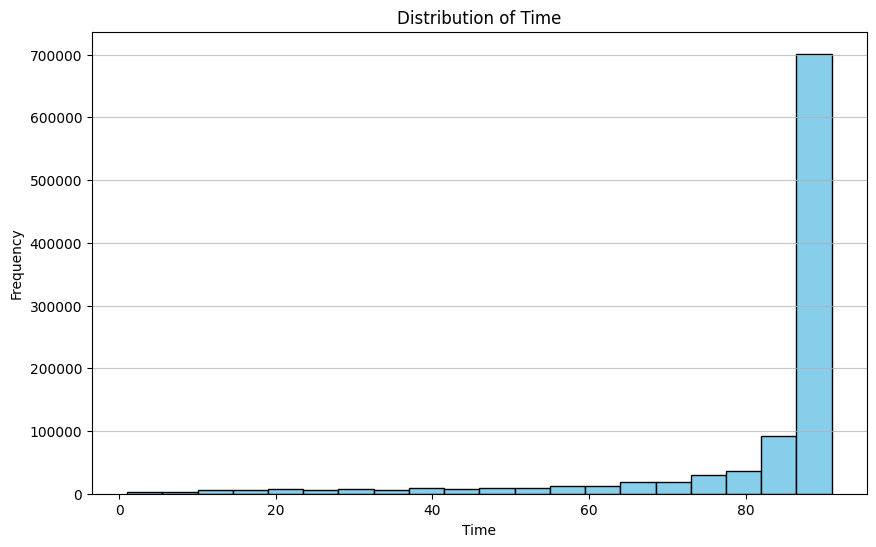

In [76]:
# Построение гистограммы для столбца 'time'
plt.figure(figsize=(10, 6))
plt.hist(train_features['time'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Time') 
plt.ylabel('Frequency') 
plt.title('Distribution of Time')
plt.grid(axis='y', alpha=0.75)
plt.show()

Прологарифмируем столбец 'time'.

Логарифмирование значений в столбце time (или любом другом столбце) может быть выполнено по нескольким причинам:

1. **Снижение влияния выбросов**: Логарифмическое преобразование помогает уменьшить влияние выбросов на анализ данных. Если у вас есть большие значения, они могут искажать результаты анализа или моделей. Логарифмирование делает большие значения менее доминирующими.

2. **Нормализация распределения**: Многие алгоритмы машинного обучения предполагают, что данные имеют нормальное (гауссовское) распределение. Если распределение значений в столбце time сильно скошено (например, имеет длинный правый хвост), логарифмическое преобразование может помочь сделать его более симметричным и ближе к нормальному.

3. **Упрощение модели**: Логарифмическое преобразование может помочь улучшить линейные зависимости между переменными. Например, если зависимость между time и целевой переменной не является линейной, логарифмирование может помочь выявить более простую или линейную связь.

4. **Интерпретация результатов**: В некоторых случаях логарифмическое преобразование может сделать интерпретацию коэффициентов модели более интуитивной. Например, если вы используете линейную регрессию, коэффициенты будут интерпретироваться как процентные изменения.

5. **Скорость роста**: Логарифмическая шкала может быть полезна для анализа данных, когда вы хотите сосредоточиться на относительном изменении, а не на абсолютных значениях.

В общем, логарифмирование — это распространенная техника предварительной обработки данных в статистике и машинном обучении, которая помогает улучшить качество моделей и облегчить анализ данных.

In [77]:
# Прологарифмируем значения в столбце 'time'
train_features['time_log'] = np.log(train_features['time'])

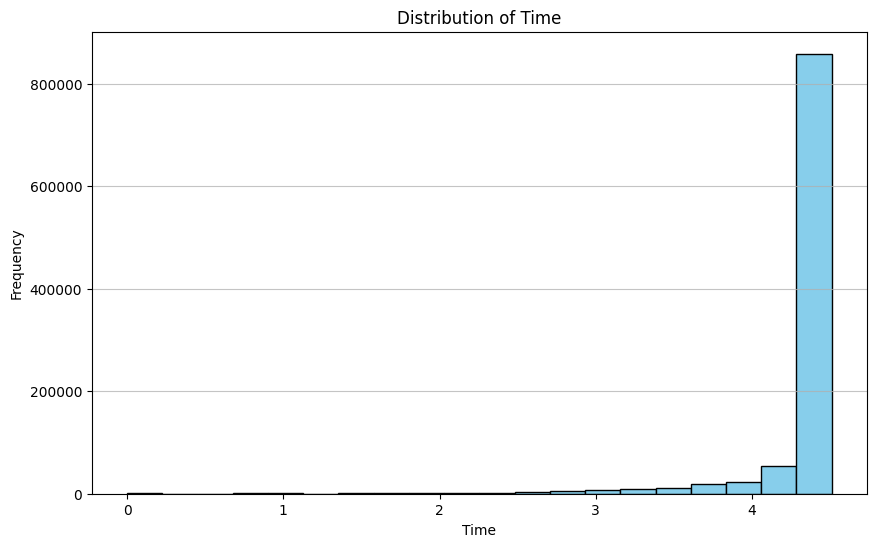

In [78]:
# Построение гистограммы для столбца 'time'
plt.figure(figsize=(10, 6))
plt.hist(train_features['time_log'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Time') 
plt.ylabel('Frequency') 
plt.title('Distribution of Time')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [79]:
# Формируем список столбцов для обучения
train_cols = [x for x in train_features.columns if x not in ['user_id', 'time', 'time_log', 'mcc_code']]

# Определяем категориальные столбцы
cat_cols = ['report', 'employee_count_nm', 'bankemplstatus', 'employee_category']

# Устанавливаем целевую переменную
target = 'time'
target_log = 'time_log'

In [80]:
# Определим функцию, которая визуализирует важность признаков модели машинного обучения
def plot_feature_importance(X_train, model, cnt):
    
    features_imp = pd.Series(model.get_feature_importance(), X_train.columns).sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(16,14))
    ax.barh(features_imp.index[:cnt], features_imp.values[:cnt])
    ax.set_title("Важность признаков")
    ax.set_ylabel('Важность, %')
    fig.tight_layout()

## 3.1.2 Обучение с прологарифмированной целевой переменной

In [81]:
# Разобъем данные на тренировочную и тестовую выборки
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(
    train_features[train_cols], 
    train_features[target_log], 
    test_size = 0.25,
    random_state = RANDOM
)

In [82]:
# # Обучаем
# model_l = CatBoostRegressor(
#     random_state=RANDOM,  # Устанавливаем случайное состояние для воспроизводимости результатов
#     loss_function='MAE',  # Указываем функцию потерь (средняя абсолютная ошибка)
#     cat_features=cat_cols,  # Указываем категориальные признаки
#     depth=6,  # Задаем максимальную глубину деревьев
#     iterations=1000  # Устанавливаем количество итераций равным 1000
# )

# # Начало отсчета времени
# start_time = time.time()
# # Обучаем модель на тренировочных данных
# model_l.fit(
#     X_train_l,  # Входные данные для обучения
#     y_train_l,  # Целевые значения для обучения
#     cat_features=cat_cols,  # Указываем категориальные признаки (повторно)
#     eval_set=(X_test_l, y_test_l),  # Указываем тестовый набор для валидации
#     early_stopping_rounds=100,  # Останавливаем обучение, если валидационная ошибка не улучшается в течение 100 итераций
#     verbose=False  # Отключаем вывод информации во время обучения
# )
# # Конец отсчета времени
# end_time = time.time()
# # Вывод времени выполнения
# print(f"Execution time: {end_time - start_time:.2f} seconds")

# # Делаем прогнозы на тренировочных данных
# train_predict_l = model_l.predict(X_train_l)

# # Делаем прогнозы на тестовых данных
# test_predict_l = model_l.predict(X_test_l)

In [83]:
# Инициализируем модель
model_l = CatBoostRegressor(
    random_state=RANDOM,  # Устанавливаем случайное состояние для воспроизводимости результатов
    loss_function='MAE',  # Указываем функцию потерь (средняя абсолютная ошибка)
    cat_features=cat_cols,  # Указываем категориальные признаки
    depth=6,  # Задаем максимальную глубину деревьев
    iterations=1000  # Устанавливаем количество итераций равным 1000
)

# Начало отсчета времени
start_time = time.time()

# Обучаем модель на тренировочных данных
model_l.fit(
    X_train_l,  # Входные данные для обучения
    y_train_l,  # Целевые значения для обучения
    cat_features=cat_cols,  # Указываем категориальные признаки (повторно)
    eval_set=(X_test_l, y_test_l),  # Указываем тестовый набор для валидации
    early_stopping_rounds=100,  # Останавливаем обучение, если валидационная ошибка не улучшается в течение 100 итераций
    verbose=False if i < model_l.get_param('iterations') else True  # Отключаем вывод информации до последней итерации
)

# Конец отсчета времени
end_time = time.time()

# Вывод времени выполнения
print(f"Execution time: {end_time - start_time:.2f} seconds")

# Делаем прогнозы на тренировочных данных
train_predict_l = model_l.predict(X_train_l)

# Делаем прогнозы на тестовых данных
test_predict_l = model_l.predict(X_test_l)

Execution time: 4530.27 seconds


In [84]:
# Проэкспонируем предсказанные значения для обучающего набора
train_predict_l = np.exp(train_predict_l)
y_train_l = np.exp(y_train_l)

# Проэкспонируем предсказанные значения для тестового набора
test_predict_l = np.exp(test_predict_l)
y_test_l = np.exp(y_test_l)

In [85]:
# Вычисляем среднюю абсолютную ошибку для тренировочных данных
mae_train_l = mean_absolute_error(y_train_l, train_predict_l)
# Вычисляем среднюю абсолютную ошибку для тестовых данных
mae_test_l = mean_absolute_error(y_test_l, test_predict_l)

# Вычисляем среднюю квадратичную ошибку для тренировочных данных
mse_train_l = mean_squared_error(y_train_l, train_predict_l)
# Вычисляем среднюю квадратичную ошибку для тестовых данных
mse_test_l = mean_squared_error(y_test_l, test_predict_l)

# Вычисляем среднюю абсолютную процентную ошибку для тренировочных данных
mape_train_l = mean_absolute_percentage_error(y_train_l, train_predict_l)
# Вычисляем среднюю абсолютную процентную ошибку для тестовых данных
mape_test_l = mean_absolute_percentage_error(y_test_l, test_predict_l)

# Выводим результаты MAE для тренировочных и тестовых данных
print('MAE train/test log:', mae_train_l, ' / ', mae_test_l)
# Выводим результаты MSE для тренировочных и тестовых данных
print('MSE train/test log:', mse_train_l, ' / ', mse_test_l)
# Выводим результаты MAPE для тренировочных и тестовых данных
print('MAPE train/test log:', mape_train_l, ' / ', mape_test_l)

MAE train/test log: 7.3419610354001446  /  7.332252558869744
MSE train/test log: 272.6443585733729  /  271.3853694606883
MAPE train/test log: 0.3428624793197593  /  0.3411920422386155


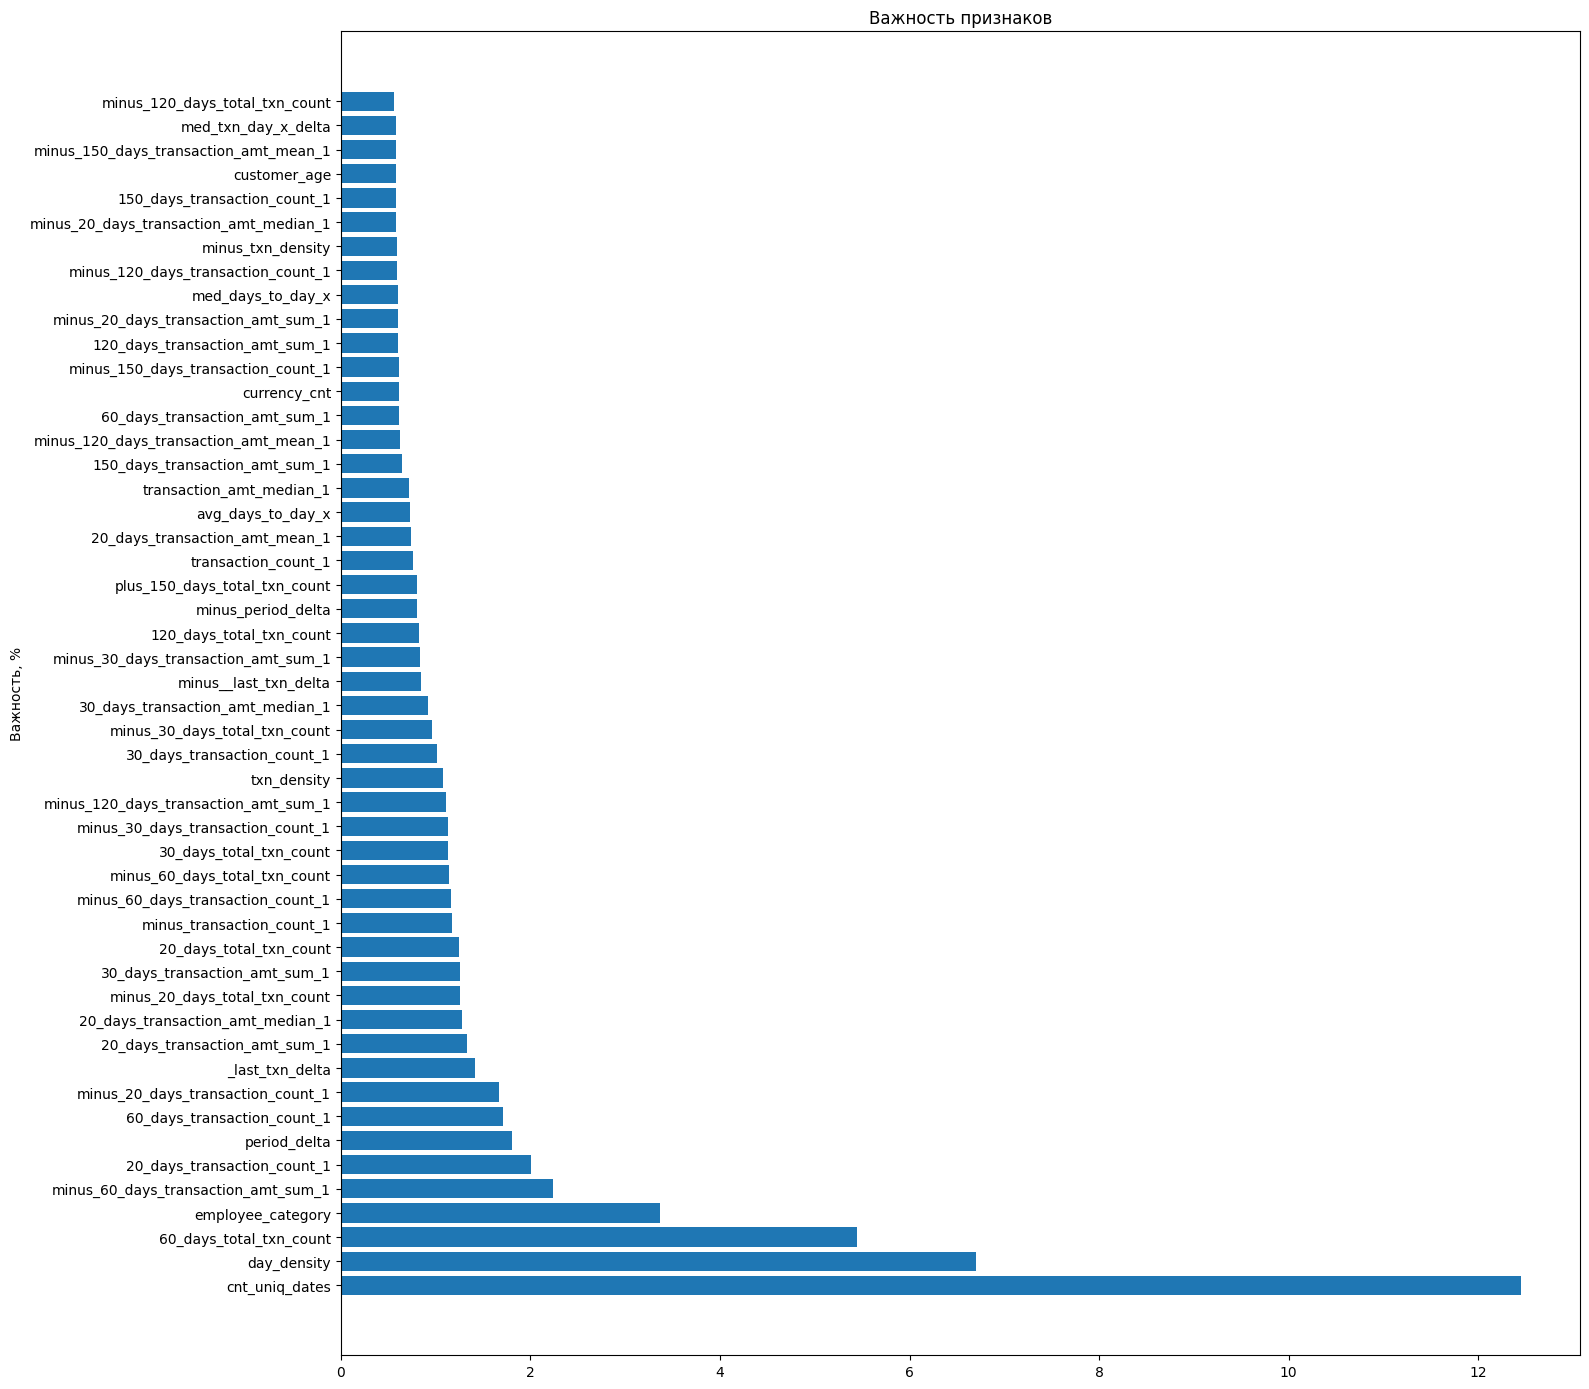

In [86]:
# Визуализация важности 50 наиболее значимых признаков модели на обучающем наборе данных X_train_l
plot_feature_importance(X_train_l, model_l, 50)

## 3.1.3 Обучение с непрологарифмированной целевой переменной

In [87]:
# Разобъем данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    train_features[train_cols], 
    train_features[target], 
    test_size = 0.25,
    random_state = RANDOM
)

In [88]:
# # Обучаем
# model = CatBoostRegressor(
#     random_state=RANDOM,  # Устанавливаем случайное состояние для воспроизводимости результатов
#     loss_function='MAE',  # Указываем функцию потерь (средняя абсолютная ошибка)
#     cat_features=cat_cols,  # Указываем категориальные признаки
#     depth=6,  # Задаем максимальную глубину деревьев
#     iterations=1000  # Устанавливаем количество итераций равным 1000
# )

# # Обучаем модель на тренировочных данных
# model.fit(
#     X_train,  # Входные данные для обучения
#     y_train,  # Целевые значения для обучения
#     cat_features=cat_cols,  # Указываем категориальные признаки (повторно)
#     eval_set=(X_test, y_test),  # Указываем тестовый набор для валидации
#     early_stopping_rounds=100,  # Останавливаем обучение, если валидационная ошибка не улучшается в течение 100 итераций
#     verbose=False  # Отключаем вывод информации во время обучения
# )

# # Делаем прогнозы на тренировочных данных
# train_predict = model.predict(X_train)

# # Делаем прогнозы на тестовых данных
# test_predict = model.predict(X_test)

In [89]:
# Инициализируем модель
model = CatBoostRegressor(
    random_state=RANDOM,  # Устанавливаем случайное состояние для воспроизводимости результатов
    loss_function='MAE',  # Указываем функцию потерь (средняя абсолютная ошибка)
    cat_features=cat_cols,  # Указываем категориальные признаки
    depth=6,  # Задаем максимальную глубину деревьев
    iterations=1000  # Устанавливаем количество итераций равным 1000
)

# Начало отсчета времени
start_time = time.time()

 # Обучаем модель на тренировочных данных
model.fit(
    X_train,  # Входные данные для обучения
    y_train,  # Целевые значения для обучения
    cat_features=cat_cols,  # Указываем категориальные признаки (повторно)
    eval_set=(X_test, y_test),  # Указываем тестовый набор для валидации
    early_stopping_rounds=100,  # Останавливаем обучение, если валидационная ошибка не улучшается в течение 100 итераций
    verbose=False if i < model.get_param('iterations') else True  # Отключаем вывод информации до последней итерации
)

# Конец отсчета времени
end_time = time.time()

# Вывод времени выполнения
print(f"Execution time: {end_time - start_time:.2f} seconds")

# Делаем прогнозы на тренировочных данных
train_predict = model.predict(X_train)

# Делаем прогнозы на тестовых данных
test_predict = model.predict(X_test)

Execution time: 4791.34 seconds


In [90]:
# Вычисляем среднюю абсолютную ошибку для тренировочных данных
mae_train = mean_absolute_error(y_train, train_predict)
# Вычисляем среднюю абсолютную ошибку для тестовых данных
mae_test = mean_absolute_error(y_test, test_predict)

# Вычисляем среднюю квадратичную ошибку для тренировочных данных
mse_train = mean_squared_error(y_train, train_predict)
# Вычисляем среднюю квадратичную ошибку для тестовых данных
mse_test = mean_squared_error(y_test, test_predict)

# Вычисляем среднюю абсолютную процентную ошибку для тренировочных данных
mape_train = mean_absolute_percentage_error(y_train, train_predict)
# Вычисляем среднюю абсолютную процентную ошибку для тестовых данных
mape_test = mean_absolute_percentage_error(y_test, test_predict)

# Выводим результаты MAE для тренировочных и тестовых данных
print('MAE train/test:', mae_train, ' / ', mae_test)
# Выводим результаты MSE для тренировочных и тестовых данных
print('MSE train/test:', mse_train, ' / ', mse_test)
# Выводим результаты MAPE для тренировочных и тестовых данных
print('MAPE train/test:', mape_train, ' / ', mape_test)

MAE train/test: 7.354682998068567  /  7.3446301421506135
MSE train/test: 274.1453320177577  /  272.8915143611266
MAPE train/test: 0.3442417458050369  /  0.34292143472705855


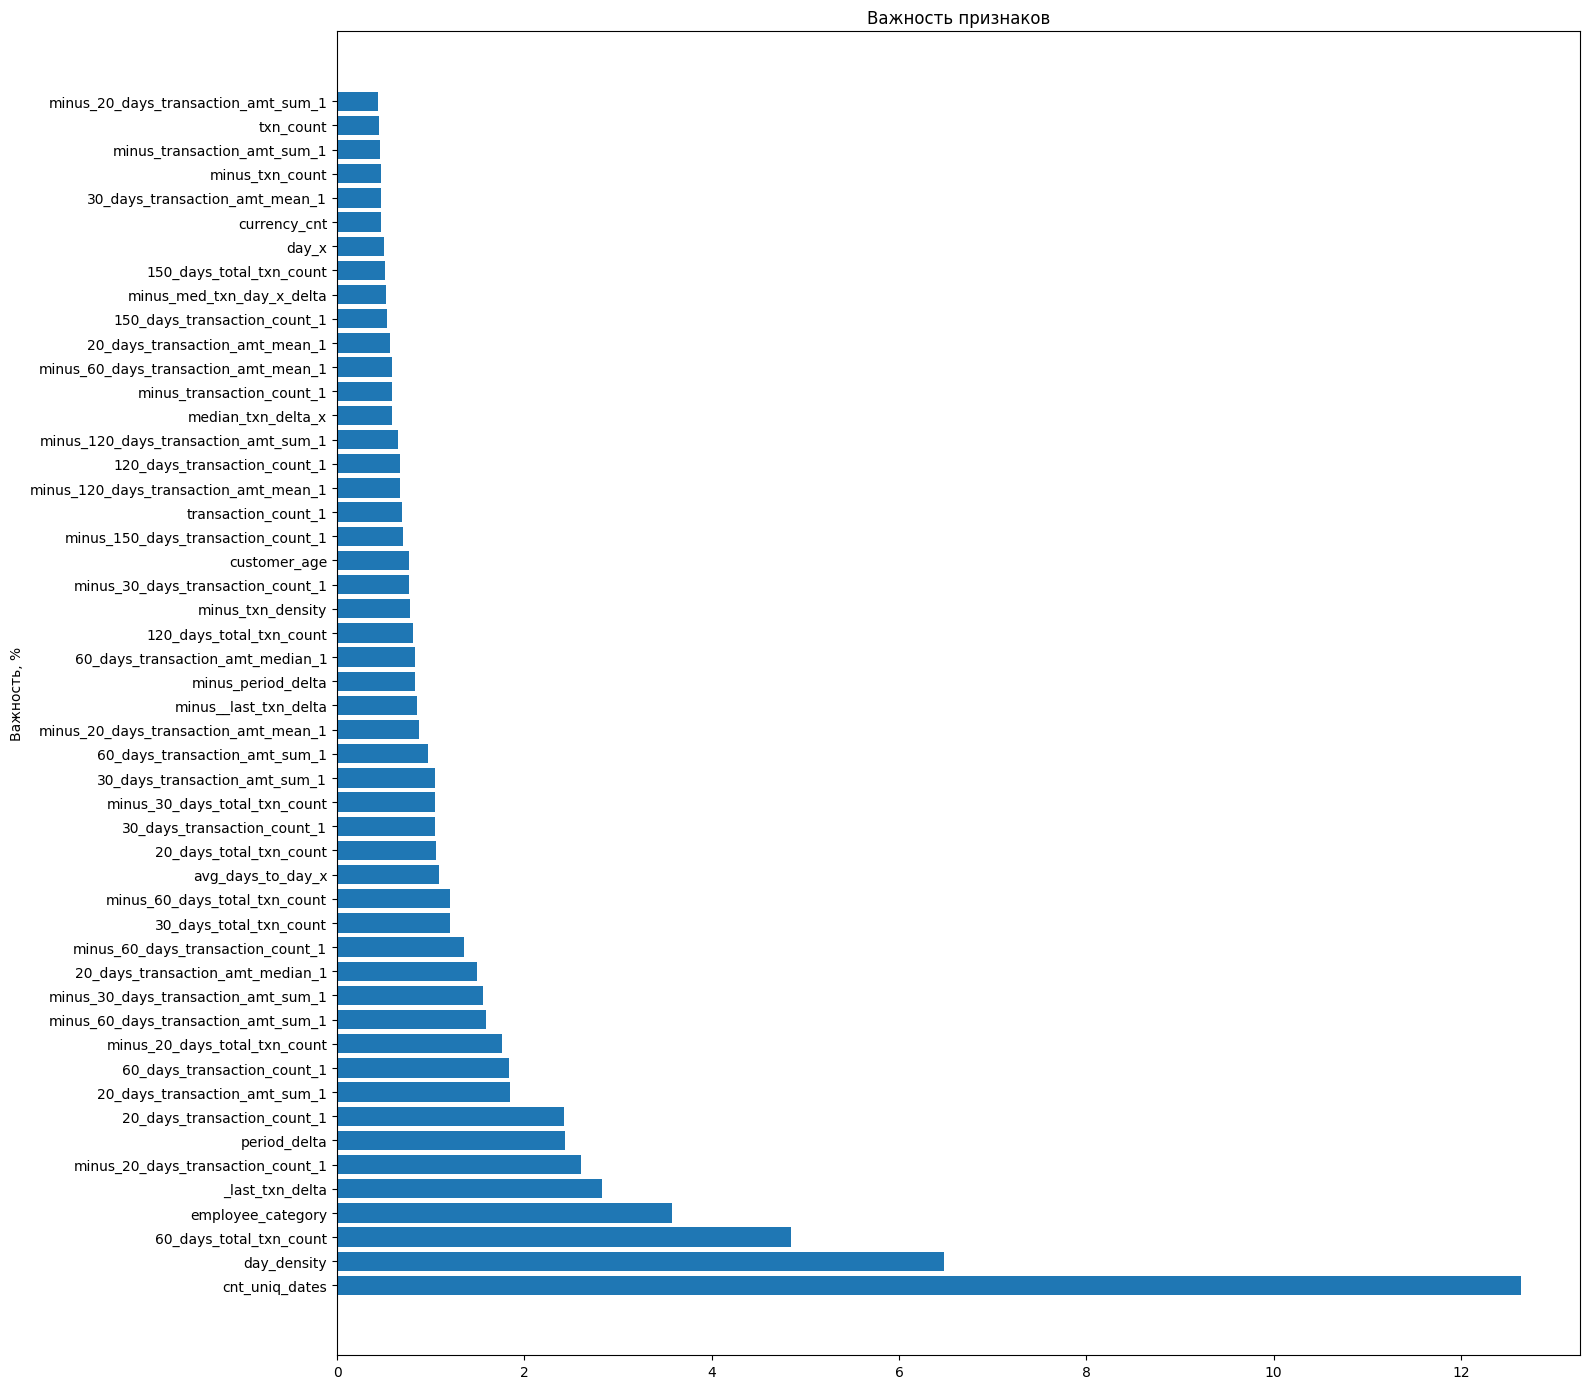

In [91]:
# Визуализация важности 50 наиболее значимых признаков модели на обучающем наборе данных X_train
plot_feature_importance(X_train, model, 50)

Разница MAE между прологарифмированной и непрологарифмированной целевой переменной незначительна, составляет тысячную долю. Оставим прологарифмированную целевую переменную.

In [92]:
# # Оставим только важные признаки
# train_cols = ['report', 'bankemplstatus', 'customer_age', 'employee_count_nm',
# 'cnt_uniq_dates',
# 'period_delta',
# 'minus_120_days_transaction_amt_sum_1',
# '20_days_transaction_count_1',
# 'minus_30_days_transaction_count_1',
# 'day_density',
# 'minus_30_days_total_txn_count',
# '30_days_transaction_count_1',
# 'minus_150_days_transaction_amt_sum_1',
# 'minus_60_days_transaction_amt_sum_1',
# 'minus_150_days_total_txn_count',
# 'minus_period_delta',
# 'last_txn_delta',
# '20_days_transaction_amt_mean_1',
# 'minus_120_days_total_txn_count',
# '20_days_transaction_amt_sum_1',
# 'minus_120_days_transaction_count_1',
# '20_days_transaction_amt_median_1',
# 'minus_60_days_transaction_count_1',
# '120_days_transaction_count_1',
# '20_days_total_txn_count',
# '60_days_total_txn_count',
# 'total_txn_count',
# '30_days_total_txn_count',
# '120_days_total_txn_count',
# 'txn_count',
# 'minus_20_days_transaction_count_1',
# 'minus_txn_count',
# '150_days_total_txn_count',
# 'minus_150_days_transaction_count_1',
# '60_days_transaction_count_1',
# '150_days_transaction_count_1',
# 'transaction_count_1',
# 'minus_60_days_total_txn_count',
# 'minus_total_txn_count',
# 'minus_20_days_total_txn_count',
# 'minus_transaction_count_1',
# 'minus_transaction_amt_sum_1',
# 'minus_30_days_transaction_amt_sum_1',
# 'minus_last_txn_delta',
# 'txn_density',
# '30_days_transaction_amt_sum_1',
# 'minus_txn_density',
# 'minus_20_days_transaction_amt_median_1',
# 'minus_20_days_transaction_amt_mean_1',
# 'minus_20_days_transaction_amt_sum_1',
# '120_days_transaction_amt_sum_1',
# '60_days_transaction_amt_sum_1',
# 'transaction_amt_sum_1',
# '30_days_transaction_amt_mean_1',
# '30_days_transaction_amt_median_1',
# '150_days_transaction_amt_sum_1',
# 'minus_30_days_transaction_amt_mean_1',
# 'minus_30_days_transaction_amt_median_1',
# 'med_txn_day_x_delta',
# 'first_txn_delta',
# 'minus_120_days_transaction_amt_mean_1',
# 'minus_150_days_transaction_amt_mean_1',
# 'minus_60_days_transaction_amt_mean_1',
# 'minus_transaction_amt_mean_1',
# 'minus_med_txn_day_x_delta',
# 'transaction_amt_mean_1',
# 'minus_first_txn_delta',
# 'minus_transaction_amt_median_1',
# 'plus_120_days_transaction_amt_median_0',
# '120_days_transaction_amt_mean_0',
# 'minus_60_days_transaction_amt_median_1',
# 'plus_120_days_transaction_amt_mean_1',
# 'plus_150_days_transaction_amt_sum_1',
# 'plus_transaction_amt_sum_1',
# 'plus_60_days_transaction_amt_mean_1',
# 'plus_150_days_transaction_amt_mean_1',
# 'plus_120_days_transaction_amt_sum_1',
# '120_days_transaction_amt_median_1',
# '120_days_transaction_amt_mean_1',
# '120_days_transaction_amt_sum_0',
# 'plus_30_days_transaction_amt_mean_1',
# 'plus_transaction_amt_median_1',
# 'plus_150_days_transaction_amt_median_1',
# 'minus_120_days_transaction_amt_median_1',
# '150_days_transaction_amt_mean_1',
# 'plus_120_days_transaction_amt_median_1',
# '150_days_transaction_amt_median_1',
# 'plus_med_txn_day_x_delta',
# 'plus_transaction_amt_mean_1',
# 'plus_60_days_transaction_amt_sum_1',
# 'minus_20_days_transaction_amt_mean_0',
# '60_days_transaction_amt_median_1',
# 'transaction_amt_median_1',
# 'plus_60_days_transaction_amt_median_1',
# 'plus_150_days_transaction_amt_median_0',
# 'plus_last_txn_delta',
# '60_days_transaction_amt_mean_1',
# 'minus_120_days_transaction_amt_median_0',
# 'minus_150_days_transaction_amt_median_0',
# 'plus_median_txn_delta',
# 'plus_first_txn_delta',
# 'plus_txn_density',
# 'minus_median_txn_delta',
# 'minus_transaction_amt_median_0',
# 'minus_150_days_transaction_amt_mean_0',
# 'plus_period_delta',
# 'minus_150_days_transaction_amt_median_1',
# 'avg_days_to_day_x',
# 'med_days_to_day_x',
# 'avg_days_to_day_x_per_mcc_last_txn'    
# ]

# cat_cols = ['report', 'bankemplstatus', 'employee_count_nm']

# target = 'time'

In [93]:
# # Формируем список столбцов для обучения
# train_cols = [x for x in train_features.columns if x not in ['user_id', 'time', 'time_log', 'mcc_code']]

# # Определяем категориальные столбцы
# cat_cols = ['report', 'employee_count_nm', 'bankemplstatus', 'employee_category']

# # Устанавливаем целевую переменную
# target = 'time'

In [94]:
# Объединяем 'features' с подмножеством 'train', состоящим из 'user_id' и 'time'
test_features = features.merge(train[['user_id', 'time']], on='user_id', how='left')

# Объединяем полученный дф 'test_features' с 'clients' по 'user_id'
test_features = test_features.merge(clients, on = 'user_id', how = 'left')

In [95]:
# Заполняем пропуски в столбце 'time' значением 'test'
test_features['time'] = test_features['time'].fillna('test')

# Оставляем только те строки, где значение 'time' равно 'test'
test_features = test_features.query('time == "test"')

# Удаляем столбец 'time' из датафрейма
test_features = test_features.drop('time', axis=1)

In [96]:
# Заполняем пропуски в столбце 'employee_count_nm' значением 'empty'
test_features['employee_count_nm'] = test_features['employee_count_nm'].fillna('empty')

In [97]:
# Преобразуем столбцы 'report', 'employee_count_nm', 'employee_category' и 'bankemplstatus' 
# в категориальный тип данных
test_features['report'] = test_features['report'].astype('category')
test_features['employee_count_nm'] = test_features['employee_count_nm'].astype('category')
test_features['bankemplstatus'] = test_features['bankemplstatus'].astype('category')
test_features['employee_category'] = test_features['employee_category'].astype('category')

In [98]:
# Используем модель для предсказания значений
predict = model_l.predict(test_features[train_cols]) 

In [99]:
# Создаем финальный DataFrame, содержащий только идентификаторы пользователей из тестовых данных
time_predict = test_features[['user_id']]

In [100]:
# Добавляем столбец 'time' в финальный DataFrame, который содержит предсказанные значения времени
time_predict['time'] = predict

# Посмотрим
time_predict.head()

user_id  time
77       572  4.51
100      731  4.50
103      777  4.46
114      897  4.34
185     1068  4.31

In [101]:
# Сохраняем финальный DataFrame в CSV файл с именем 'test_time_predict.csv'
time_predict.to_csv('test_time_predict.csv')